### Color palette

- #5565cf — bluish tone
- #b14ecf — purple-pink tone
- #cf4773 — reddish tone
- #cf913f — orange-brown tone
- #87cf38 — greenish tone
- #30cf6b — bright green
- #29a1cf — cyan tone
- #2138cf — deep blue

In [1]:
# imports
import os
import json
import re
import pandas as pd
from collections import Counter
import pprint as pp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
import seaborn as sns
from collections import defaultdict
import requests
import time
import uuid
import hashlib
import base64

folder_path = 'data_stories'

data_stories_summary_file = 'data_stories_summary.json'

color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

id_mapping_file = 'id_mapping.json'

In [6]:
data_stories_summary = {}
user_names_hands_on = []
user_names_general = []
id_mapping = {}

if os.path.exists(id_mapping_file):
    with open(id_mapping_file, 'r') as file:
        id_mapping = json.load(file)

def generate_anonym_id(story_id):
    hashed = hashlib.sha256(story_id.encode()).digest()
    anonym_id = base64.urlsafe_b64encode(hashed).decode()[:8]
    return anonym_id

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Check if the file is a JSON file
        file_path = os.path.join(folder_path, filename)
        
        with open(file_path, 'r') as file:
            data_stories_summary_data = json.load(file)

            # Generate or retrieve an anonymous ID for the story
            story_id = data_stories_summary_data['id']
            if story_id not in id_mapping:
                anonym_id = generate_anonym_id(story_id)
                id_mapping[story_id] = anonym_id
            else:
                anonym_id = id_mapping[story_id]

            # empty dict to store information
            story_info = {}
            story_title = data_stories_summary_data['title']
            dynamic_elements = data_stories_summary_data['dynamic_elements']

            if 'hands-' not in story_title.lower() and 'hans-' not in story_title.lower():
                pass
            else:
                user_names_hands_on.append(data_stories_summary_data['user_name'])

            if 'hands-' not in story_title.lower() and 'hans-' not in story_title.lower() and len(dynamic_elements) >= 3:
                user_names_general.append(data_stories_summary_data['user_name'])
                story_info['title'] = story_title.strip()
                story_info['sparql_endpoint'] = data_stories_summary_data['sparql_endpoint']
                story_info['user_name'] = data_stories_summary_data['user_name']
                curators = re.split(r'\s*[-,;&]\s*|\s+and\s+', data_stories_summary_data['curator'].strip())

                text_elements = []

                story_info['curators'] = curators
                elements_order = {}
                el_order_num = 1
                elements = []
                viz_types = []
                queries = []

                # use description as text in first element position if not empty
                story_description = data_stories_summary_data['description']
                if len(story_description) > 0:
                    elements_order[el_order_num] = 'text'
                    el_order_num+=1
                    elements.append('text')
                    text_elements.append(re.sub(r'\s+', ' ', story_description).strip())

                for el in data_stories_summary_data['dynamic_elements']:
                    if el['type'] != 'action':
                        if el['type'] == 'map' or el['type'] == 'table':
                            elements_order[el_order_num] = 'data viz'
                            elements.append('data viz')
                            viz_types.append(el['type'])
                            el_order_num+=1
                        elif el['type'] == 'chart':
                            elements_order[el_order_num] = 'data viz'
                            el_order_num+=1
                            elements.append('data viz')
                            viz_types.append(el['chart_type'])
                        else:
                            elements_order[el_order_num] = el['type']
                            elements.append(el['type'])
                            el_order_num+=1
                    if el['type'] == 'text':
                        text_elements.append(re.sub(r'\s+', ' ', el['text']).strip())

                    for k in el.keys():
                        query_dict = {}
                        if any(query in k for query in ['count_query', 'table_query', 'map_points_query', 'chart_query', 'textsearch_query']):
                            # query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', el[k])
                            # queries.append(re.sub(r'\s+', ' ', el[k]).strip())
                            if el['type'] == 'chart':
                                query_dict['type'] = el['chart_type']
                            else:
                                query_dict['type'] = el['type']
                            if el['type'] == 'textsearch':
                                if 'textsearch' in el:
                                    query_dict['actions'] = el['textsearch']
                                else:
                                    query_dict['actions'] = {}
                            query_dict['query'] = el[k]
                            queries.append(query_dict)
                story_info['elements_order'] = elements_order
                story_info['elements'] = elements
                story_info['viz_types'] = viz_types
                story_info['queries'] = queries
                story_info['texts'] = text_elements

                data_stories_summary[anonym_id] = story_info

with open(data_stories_summary_file, 'w') as file:
    json.dump(data_stories_summary, file, indent=4)

 # Save the id mapping to a file
with open(id_mapping_file, 'w') as file:
    json.dump(id_mapping, file, indent=4)

# print(data_stories_summary)

In [4]:
print('Hands-on users',len(set(user_names_hands_on)), set(user_names_hands_on))
print('Other users', len(set(user_names_general)), set(user_names_general))

# Find the intersection of the two sets
intersection = set(user_names_hands_on).intersection(set(user_names_general))
count = len(intersection)
print(f"There are {count} elements from set1 in set2.")

NameError: name 'user_names_hands_on' is not defined

In [3]:
user_stories = {}
for user in set(user_names_general):
    user_stories[user] = []

print(user_stories)

NameError: name 'user_names_general' is not defined

### Element Usage Analysis

In [5]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

elements_list = []
viz_types_list = []
element_story_count = defaultdict(int)
viz_story_count = defaultdict(int)

# Loop through each story and count unique elements per story
for story_id, story_data in data.items():
    elements = set(story_data.get("elements", []))
    data_viz = set(story_data.get("viz_types", []))
    for element in elements:
        element_story_count[element] += 1
    for viz in data_viz:
        viz_story_count[viz] += 1

for story_id, story_data in data.items():
    # elements = story_data.get("elements", [])
    elements_list.extend(story_data.get("elements", []))
    viz_types_list.extend(story_data.get("viz_types", []))

    # user_stories_list = user_stories[story_data['user_name']]
    # user_stories_list.append(story_data['title'].strip())
    # user_stories['user_name'] = user_stories_list

# Count frequency of each element and chart type
element_counts = Counter(elements_list)
chart_type_counts = Counter(viz_types_list)

# Convert to DataFrame for better visualization
elements_df = pd.DataFrame(element_counts.items(), columns=["Element", "Count"])
elements_df["Story Count"] = elements_df["Element"].map(element_story_count)
elements_df = elements_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

viz_types_df = pd.DataFrame(chart_type_counts.items(), columns=["Data Viz Type", "Count"])
viz_types_df["Story Count"] = viz_types_df["Data Viz Type"].map(viz_story_count)
viz_types_df = viz_types_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

print(f'Total Number of Data Stories: {len(data)}')
print("Element Usage Frequency:")
print(elements_df)

print("\nChart Type Usage Frequency:")
print(viz_types_df)

Total Number of Data Stories: 51
Element Usage Frequency:
      Element  Count  Story Count
0    data viz    329           50
1        text    244           48
2       count    106           48
3  textsearch     29           29

Chart Type Usage Frequency:
   Data Viz Type  Count  Story Count
0          table    173           46
1  doughnutchart     52           45
2            map     44           33
3       barchart     36           32
4      linechart     23           20
5    scatterplot      1            1


In [6]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

data_sources_list = []

service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

for story_id, story_data in data.items():
    data_sources_list.append(story_data["sparql_endpoint"].split("//")[1])
    queries = story_data.get('queries', [])

    for query_dict in queries:
        query = re.sub(r'\s+', ' ', query_dict['query']).strip()
        service_matches = service_pattern.findall(query)
        for service_url in service_matches:
            if service_url:
                data_sources_list.append(service_url.split("//")[1])


data_sources_counts = Counter(data_sources_list)
data_sources_df = pd.DataFrame(data_sources_counts.items(), columns=["Source Type", "Count"])

print("\nSource Type Usage Frequency:")
print(data_sources_df)


Source Type Usage Frequency:
                                         Source Type  Count
0                          query.wikidata.org/sparql     42
1             polifonia.disi.unibo.it/musicbo/sparql      6
2    query.wikidata.org/bigdata/namespace/wdq/sparql     23
3                                 dbpedia.org/sparql      4
4                         dati.cultura.gov.it/sparql      1
5  triplestore.netwerkdigitaalerfgoed.nl/reposito...      1


In [9]:
pp.pprint(user_stories)

{'Alenkanaaa': ['The Beatles'],
 'AlessiaMazza': ['Gaspare Spontini'],
 'AlessiaValentini': ['Dolly Parton: The Queen of Country Music',
                      "The Destiny's Child"],
 'Carmela-Saracino': ['ABBA - An Overview'],
 'DariaKanev': ['Orchestra exploration on MusicBo',
                'Orchestras around the world'],
 'Ele-cerasella': ['Jazz musicians born in Bologna'],
 'Elena875': ['the violin', 'Exploring musical instruments: the violin'],
 'EleonoraPellegrini': ['Theatres in the UK and classical music'],
 'FabianaCei': ['Pinguini Tattici Nucleari - test'],
 'Ilariamassa': ['Indie rock music: Blur and Sonic Youth'],
 'Isabela-Serrano': ['Italian Rock Bands'],
 'Lada-unibo': ['Russian Rock Bands'],
 'Lorenzopetrucci': ['Exploring the life and works of Johann Sebastian Bach'],
 'MatteoPu': ['Imagine Dragons'],
 'RossellaVerolino': ['Exploring musical instruments: the piano'],
 'Serena2796': ['Discovering Rock Bands in Spain',
                'Discovering Rock Bands in the USA

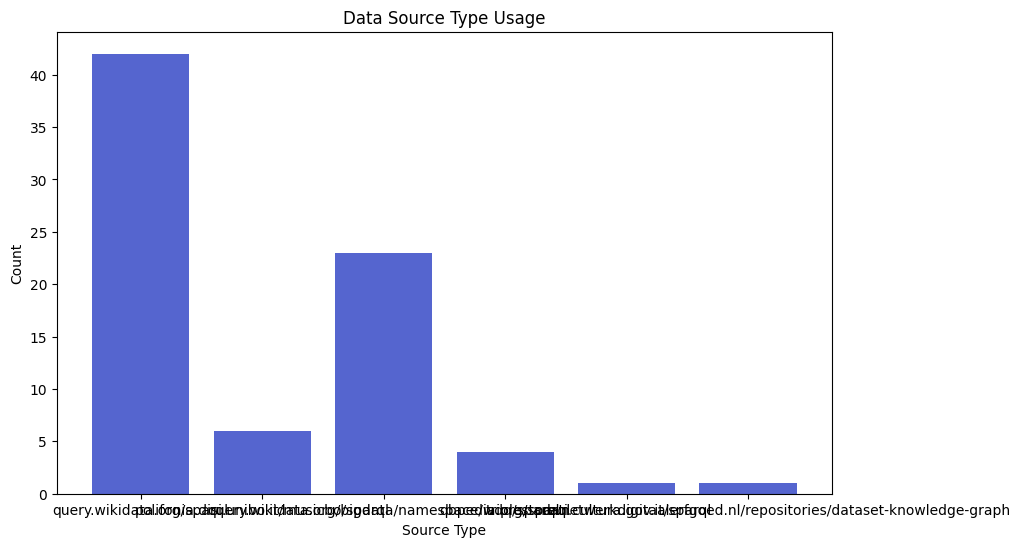

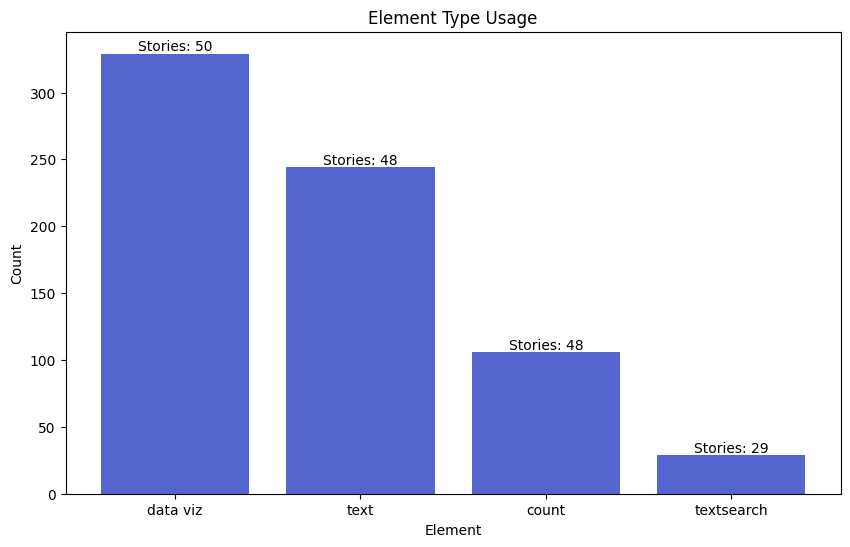

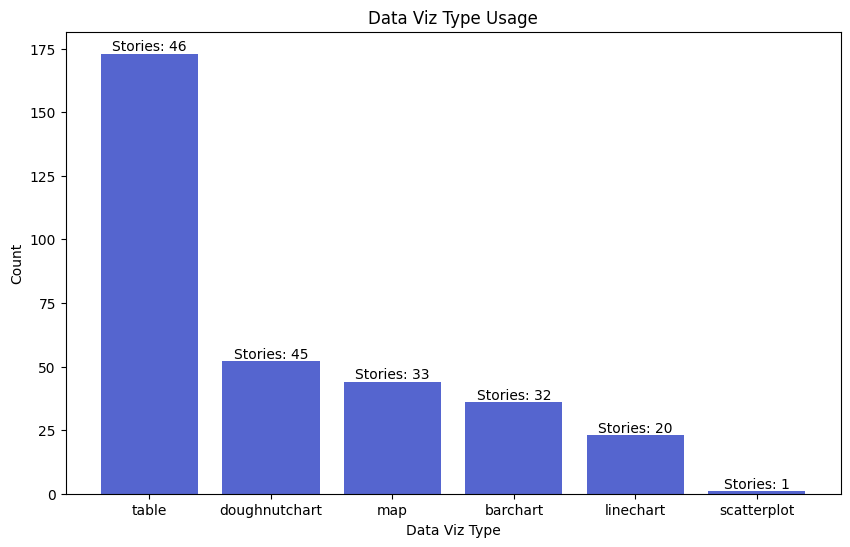

In [23]:
# Plot sata source type usage
plt.figure(figsize=(10, 6))
plt.bar(data_sources_df['Source Type'], data_sources_df['Count'], color=color_palette[0])
plt.title('Data Source Type Usage')
plt.xlabel('Source Type')
plt.ylabel('Count')
plt.show()

# Plot element usage
plt.figure(figsize=(10, 6))
bars = plt.bar(elements_df['Element'], elements_df['Count'], color=color_palette[0])
plt.title('Element Type Usage')
plt.xlabel('Element')
plt.ylabel('Count')
for bar, story_count in zip(bars, elements_df["Story Count"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'Stories: {story_count}', ha='center', va='bottom')
plt.show()

# Plot chart type usage
plt.figure(figsize=(10, 6))
viz_bars = plt.bar(viz_types_df['Data Viz Type'], viz_types_df['Count'], color=color_palette[0])
plt.title('Data Viz Type Usage')
plt.xlabel('Data Viz Type')
plt.ylabel('Count')
for bar, story_count in zip(viz_bars, viz_types_df["Story Count"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'Stories: {story_count}', ha='center', va='bottom')
plt.show()

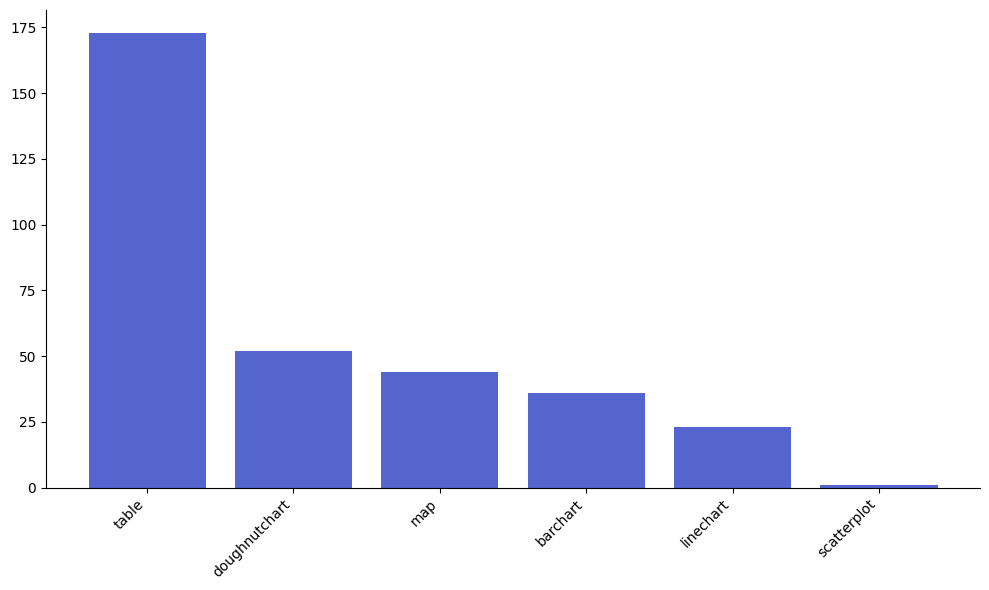

In [9]:
# Plot chart type usage
plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(viz_types_df['Data Viz Type'], viz_types_df['Count'], color=color_palette[0])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Remove all spines except for the bottom and left axes
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


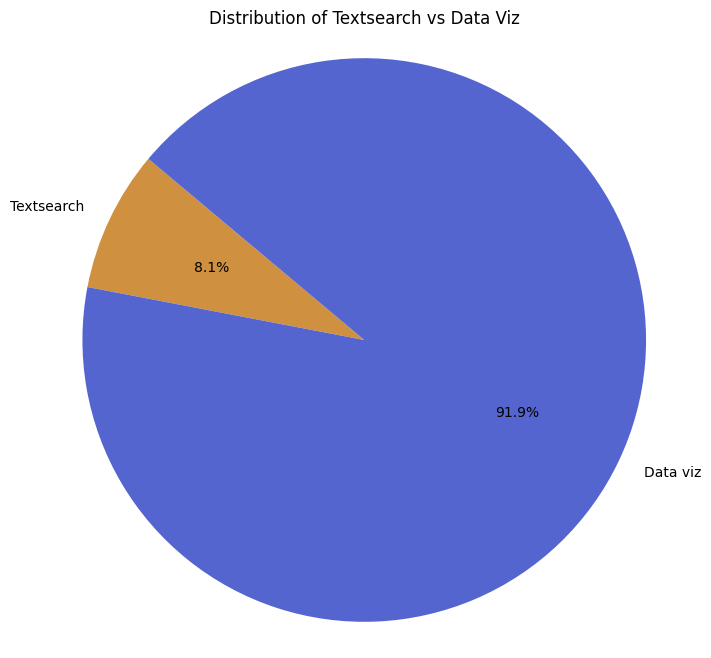

In [24]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize counters
textsearch_count = 0
chart_table_count = 0

# Iterate over each story
for story_id, story_data in data.items():
    # Count textsearch elements
    textsearch_count += story_data['elements'].count('textsearch')
    
    # Count charts and tables
    chart_table_count += len(story_data.get('viz_types', []))

# pie chart to visualize the distribution
labels = ['Textsearch', 'Data viz']
sizes = [textsearch_count, chart_table_count]
colors = [color_palette[3],color_palette[0]]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Textsearch vs Data Viz')
plt.axis('equal')
plt.show()

### Text search Analysis

Textsearches per Data Story: Max = 1, Min = 0, Avg = 0.57
Actions per Textsearch: Max = 11, Min = 0, Avg = 2.14


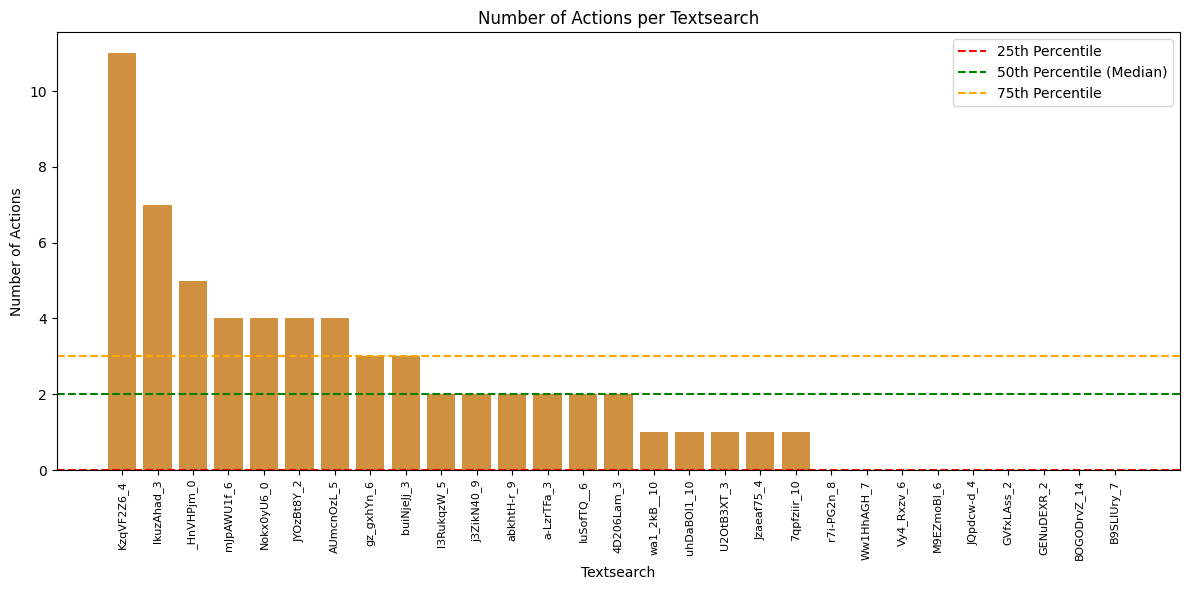

25th Percentile: 0.0
50th Percentile (Median): 2.0
75th Percentile: 3.0


In [34]:
with open(data_stories_summary_file, 'r') as f:
    data_stories_summary = json.load(f)

textsearch_labels = []  # Labels for the X-axis (can be an index)
actions_per_textsearch = []  # Number of actions per textsearch
textsearches_per_story = []  # Number of textsearches per data story

# Loop over all data stories
for story_id, story_data in data_stories_summary.items():
    textsearch_count = 0  # Count textsearches in each data story
    for idx, textsearch in enumerate(story_data.get('queries', [])):
        if textsearch['type'] == 'textsearch':
            textsearch_count += 1
            textsearch_labels.append(f"{story_id}_{idx}")
            # Count the total number of actions in this textsearch
            actions = textsearch.get('actions', {})
            num_actions = sum(len(action_list) for action_list in actions.values())
            actions_per_textsearch.append(num_actions)
    
    textsearches_per_story.append(textsearch_count)

# Calculate statistics for textsearches per data story
max_textsearches = max(textsearches_per_story)
min_textsearches = min(textsearches_per_story)
avg_textsearches = np.mean(textsearches_per_story)

# Calculate statistics for actions per textsearch
max_actions = max(actions_per_textsearch)
min_actions = min(actions_per_textsearch)
avg_actions = np.mean(actions_per_textsearch)

# Print statistics
print(f"Textsearches per Data Story: Max = {max_textsearches}, Min = {min_textsearches}, Avg = {avg_textsearches:.2f}")
print(f"Actions per Textsearch: Max = {max_actions}, Min = {min_actions}, Avg = {avg_actions:.2f}")

sorted_data = sorted(zip(actions_per_textsearch, textsearch_labels), reverse=True)
sorted_actions_per_textsearch, sorted_textsearch_labels = zip(*sorted_data)

# Calculate percentiles
p25 = np.percentile(sorted_actions_per_textsearch, 25)
p50 = np.percentile(sorted_actions_per_textsearch, 50)
p75 = np.percentile(sorted_actions_per_textsearch, 75)

# Bar Chart (Textsearches vs. Number of Actions)
plt.figure(figsize=(12, 6))
plt.bar(sorted_textsearch_labels, sorted_actions_per_textsearch, color=color_palette[3])
plt.xticks(rotation=90, fontsize=8)
plt.title('Number of Actions per Textsearch')
plt.xlabel('Textsearch')
plt.ylabel('Number of Actions')
plt.axhline(p25, color='red', linestyle='--', label='25th Percentile')
plt.axhline(p50, color='green', linestyle='--', label='50th Percentile (Median)')
plt.axhline(p75, color='orange', linestyle='--', label='75th Percentile')
plt.legend()
plt.tight_layout()
plt.show()
print(f"25th Percentile: {p25}")
print(f"50th Percentile (Median): {p50}")
print(f"75th Percentile: {p75}")

### Correlation N. curators / n. of charts

Pearson correlation coefficient (r): 0.12


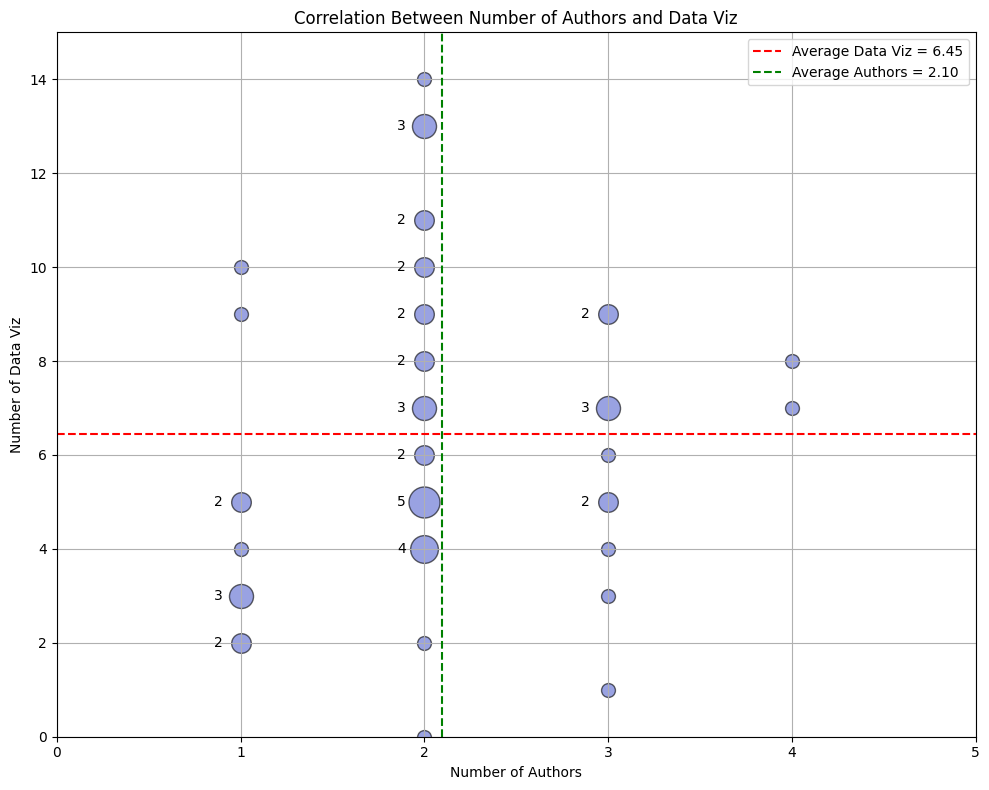

In [49]:
num_authors = []
num_charts = []

with open(data_stories_summary_file, 'r') as f:
    data = json.load(f)

# Extract the number of authors and charts
for story_id, story_data in data.items():
    # Count the number of curators
    authors = story_data.get('curators', [])
    num_authors.append(len(authors))
    
    # Count the number of charts
    charts = [viz for viz in story_data.get('viz_types', []) 
              if viz in ['barchart', 'linechart', 'doughnutchart', 'scatterplot', 'map', 'table']]
    num_charts.append(len(charts))

# Calculate averages for the average line
avg_authors = np.mean(num_authors)
avg_charts = np.mean(num_charts)

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(num_authors, num_charts)[0, 1]
print(f'Pearson correlation coefficient (r): {correlation:.2f}')

data_points = list(zip(num_authors, num_charts))
counts = Counter(data_points)

plt.figure(figsize=(10, 8))

for point, count in counts.items():
    plt.scatter(point[0], point[1], 
                s=100 * count,
                color=color_palette[0], 
                alpha=0.6, 
                edgecolors='black')
    
    if count > 1:  # Only annotate if there's an overlap
        plt.text(point[0] - 0.1, point[1], str(count), fontsize=10, ha='right', va='center')

# Add average lines
plt.axhline(y=avg_charts, color='red', linestyle='dashed', label=f'Average Data Viz = {avg_charts:.2f}')
plt.axvline(x=avg_authors, color='green', linestyle='dashed', label=f'Average Authors = {avg_authors:.2f}')

# Set axis limits
plt.xlim(0, max(num_authors) + 1)
plt.ylim(0, max(num_charts) + 1)


plt.title('Correlation Between Number of Authors and Data Viz')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Data Viz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It appears that there isn't a strong or clear correlation between the number of authors (curators) and the number of charts.
1. No Clear Trend:
   1. There doesn't seem to be a clear increasing or decreasing trend between the number of authors and the number of charts.
   2. For example, with 2 authors, there is a wide range of charts (from 2 to 14), making it difficult to establish a pattern.
2. Clustered Data:
   1. The data points are clustered around 1 to 3 authors, but the number of charts varies significantly within those clusters.
   2. This suggests that the number of charts might not be strongly dependent on the number of authors.
3. Chart quantity:
   1. Distributed unevenly. For instance, a data story with 1 author might have as many charts as a story with 3 or 4 authors, indicating variability in chart quantity that's not closely tied to the number of curators.

Pearson correlation coefficient (r): 0.24


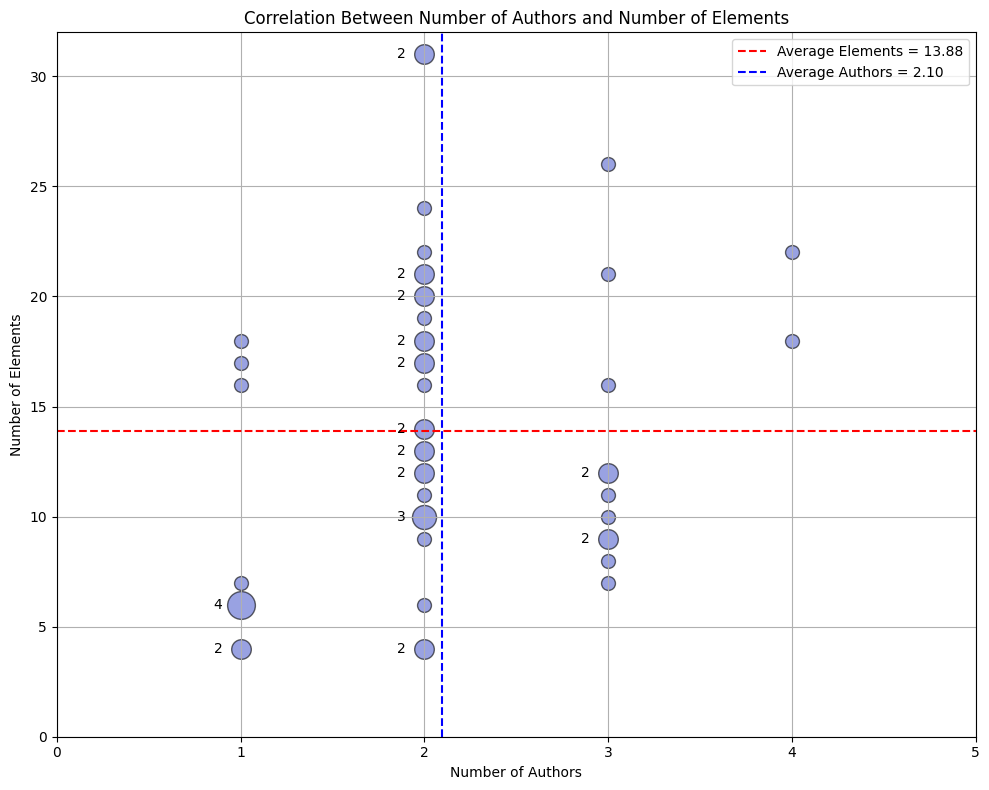

In [46]:
num_authors = []
num_elements = []

for story_id, story_data in data.items():
    # Count the number of authors (curators)
    authors = story_data.get('curators', [])
    num_authors.append(len(authors))
    
    # Count the number of elements
    elements = story_data.get('elements', [])
    num_elements.append(len(elements))

# Calculate averages for the average line
avg_authors = np.mean(num_authors)
avg_elements = np.mean(num_elements)

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(num_authors, num_elements)[0, 1]
print(f'Pearson correlation coefficient (r): {correlation:.2f}')

# Count occurrences of each (x, y) pair
data_points = list(zip(num_authors, num_elements))
counts = Counter(data_points)

plt.figure(figsize=(10, 8))

for point, count in counts.items():
    plt.scatter(point[0], point[1], 
                s=100 * count,
                color=color_palette[0], 
                alpha=0.6, 
                edgecolors='black')
    
    if count > 1:  # Only annotate overlaps
        plt.text(point[0] - 0.1, point[1], str(count), fontsize=10, ha='right', va='center')

# Add average lines
plt.axhline(y=avg_elements, color='red', linestyle='dashed', label=f'Average Elements = {avg_elements:.2f}')
plt.axvline(x=avg_authors, color='blue', linestyle='dashed', label=f'Average Authors = {avg_authors:.2f}')

# Set axis limits
plt.xlim(0, max(num_authors) + 1)
plt.ylim(0, max(num_elements) + 1)


plt.title('Correlation Between Number of Authors and Number of Elements')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Elements')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Pearson correlation coefficient of 0.14 indicates a very weak positive correlation between the number of authors and the number of elements in the data stories. This suggests that there is no significant linear relationship between these two variables.

- The plot shows a wide spread of data points, particularly for stories with 1 or 2 authors, where the number of elements ranges quite significantly.
- There is no clear upward or downward trend, indicating that increasing the number of authors doesn't strongly predict the number of elements in the story.

The weak correlation suggests that the number of authors in a story doesn’t significantly affect the number of elements in that story. In other words, stories with more curators are not necessarily longer or more complex in terms of the number of elements.
There is a visible cluster of data points around 2 authors, but the number of elements within this group is highly variable, further supporting the idea of a weak correlation.

### Variety of elements in the same story

In [3]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

story_elements = {}

for story_id, story_data in data.items():
    story_elements[story_id] = story_data['elements_order']

# Initialize an empty DataFrame
df = pd.DataFrame()

# Process each stories's data
for story, elements in story_elements.items():
    # Create a temporary df for the current story
    temp_df = pd.DataFrame.from_dict(elements, orient='index', columns=[story])
    
    # Transpose to have the order as columns and the story as rows
    temp_df = temp_df.T
    
    # Append the data to the main df
    df = pd.concat([df, temp_df], sort=False)

# Display the DataFrame
print(df)

                 1           2         3           4           5           6  \
D-hp3wDV      text       count     count    data viz    data viz    data viz   
y4Srva15      text       count  data viz    data viz    data viz    data viz   
7qpfziir      text        text     count       count       count        text   
Nokx0yU6      text  textsearch  data viz    data viz         NaN         NaN   
gz_gxhYn      text       count     count       count        text    data viz   
U2OtB3XT      text        text     count        text       count        text   
v4h_GSI0      text       count  data viz    data viz        text    data viz   
1ptR3pru      text       count     count    data viz    data viz    data viz   
JQpdcw-d      text        text     count       count    data viz    data viz   
B9SLlUry      text       count     count    data viz    data viz    data viz   
r7i-PG2n      text        text     count       count        text    data viz   
AUmcnOzL      text       count      text

C:\Users\giuli\AppData\Local\Temp\ipykernel_16800\1461798331.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  index_mapped_df = df.applymap(lambda x: label_to_index.get(x) if pd.notna(x) else np.nan)


51


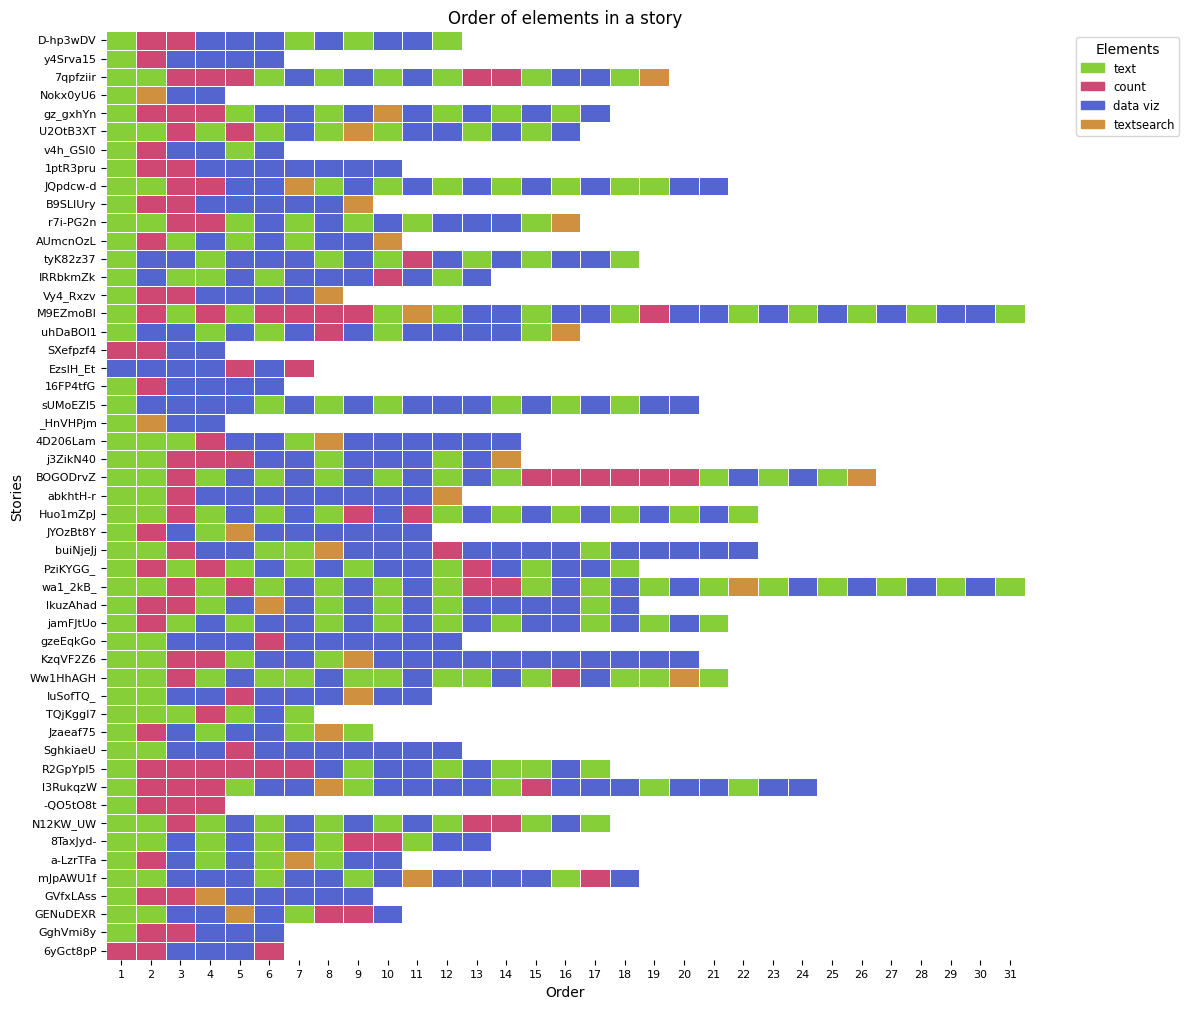

In [5]:
# Get unique elements for the legend
unique_labels = pd.unique(df.values.ravel('K'))
unique_labels = [label for label in unique_labels if pd.notna(label)]

# Create a mapping from labels to indices
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map the df values to indices, ignoring NaNs
index_mapped_df = df.applymap(lambda x: label_to_index.get(x) if pd.notna(x) else np.nan)

# Dynamically set figure size based on the number of rows (stories)
num_stories = index_mapped_df.shape[0]
fig_width = 12  # Keep width constant
fig_height = max(8, num_stories * 0.2)  # Adjust height, minimum of 8

# Create the color map
cmap = sns.color_palette([color_palette[4], color_palette[2], color_palette[0], color_palette[3]], len(unique_labels))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels)+1)-0.5, ncolors=len(unique_labels))

# Plot the heatmap
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(index_mapped_df, cmap=mcolors.ListedColormap(cmap), norm=norm, linewidths=.5, cbar=False, mask=index_mapped_df.isna())

# Add the legend
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap[i]) for i in range(len(unique_labels))]
plt.legend(handles, unique_labels, title="Elements", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Customize the plot
plt.title('Order of elements in a story', fontsize=12)
plt.xlabel('Order', fontsize=10)
plt.ylabel('Stories', fontsize=10)

# Adjust tick label font size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutoff
plt.show()


38


C:\Users\giuli\AppData\Local\Temp\ipykernel_16800\2022740227.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  index_mapped_filtered_df = filtered_df.applymap(lambda x: label_to_index.get(x) if pd.notna(x) else np.nan)


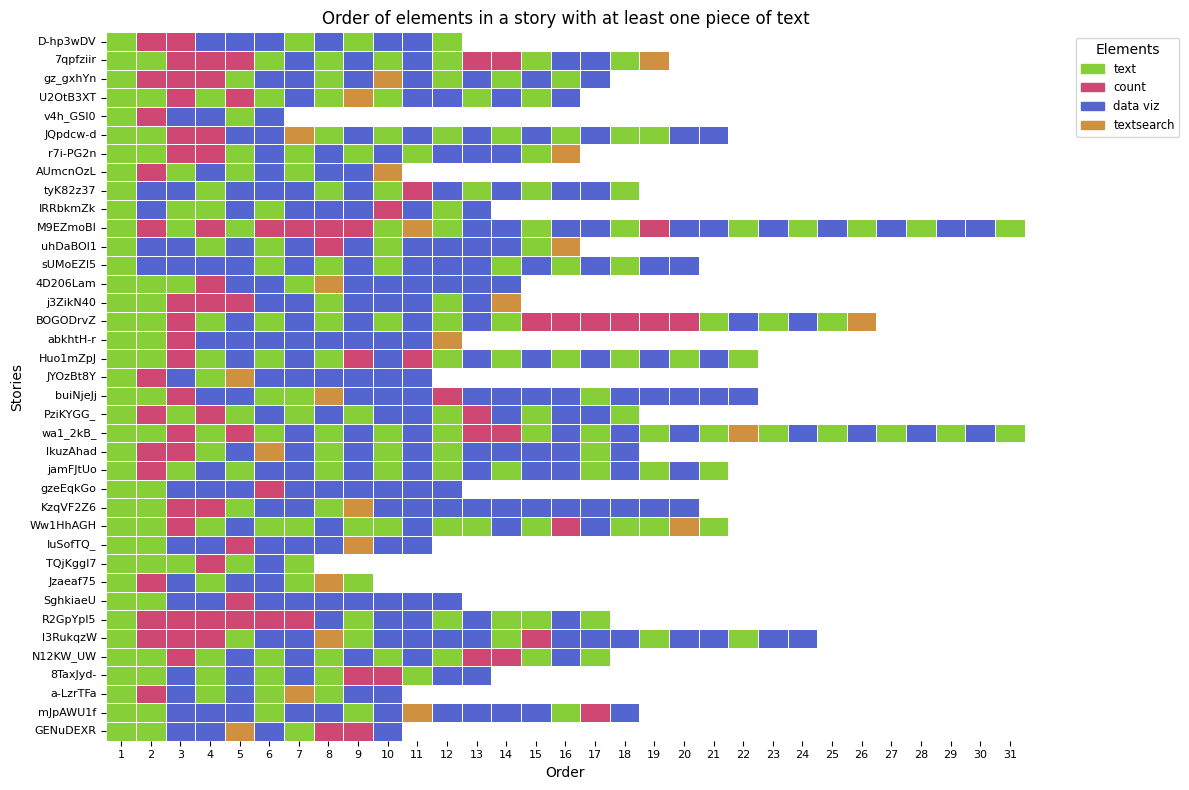

In [ ]:
# Select rows where 'text' is in any cell excluding column 1
filtered_df = df[df.iloc[:, 1:].apply(lambda row: (row == 'text').any(), axis=1)]
# filtered_df = df[df.apply(lambda row: (row == 'text').any(), axis=1)]
print(len(filtered_df))

# Get unique elements for the legend
unique_labels = pd.unique(filtered_df.values.ravel('K'))
unique_labels = [label for label in unique_labels if pd.notna(label)]

# Create a mapping from labels to indices
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map the filtered_df values to indices, ignoring NaNs
index_mapped_filtered_df = filtered_df.applymap(lambda x: label_to_index.get(x) if pd.notna(x) else np.nan)

# Dynamically set figure size based on the number of rows (stories)
num_filtered_stories = index_mapped_filtered_df.shape[0]
fig_width = 12  # Keep width constant
fig_height = max(8, num_filtered_stories * 0.2)  # Adjust height, minimum of 8

# Create the color map
cmap = sns.color_palette([color_palette[4], color_palette[2], color_palette[0], color_palette[3]], len(unique_labels))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels)+1)-0.5, ncolors=len(unique_labels))

# Plot the heatmap, masking NaN values
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(index_mapped_filtered_df, cmap=mcolors.ListedColormap(cmap), norm=norm, linewidths=.5, cbar=False, mask=index_mapped_filtered_df.isna())

# Add the legend
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap[i]) for i in range(len(unique_labels))]
plt.legend(handles, unique_labels, title="Elements", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Customize the plot
plt.title('Order of elements in a story with at least one piece of text', fontsize=12)
plt.xlabel('Order', fontsize=10)
plt.ylabel('Stories', fontsize=10)

# Adjust tick label font size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


### General order

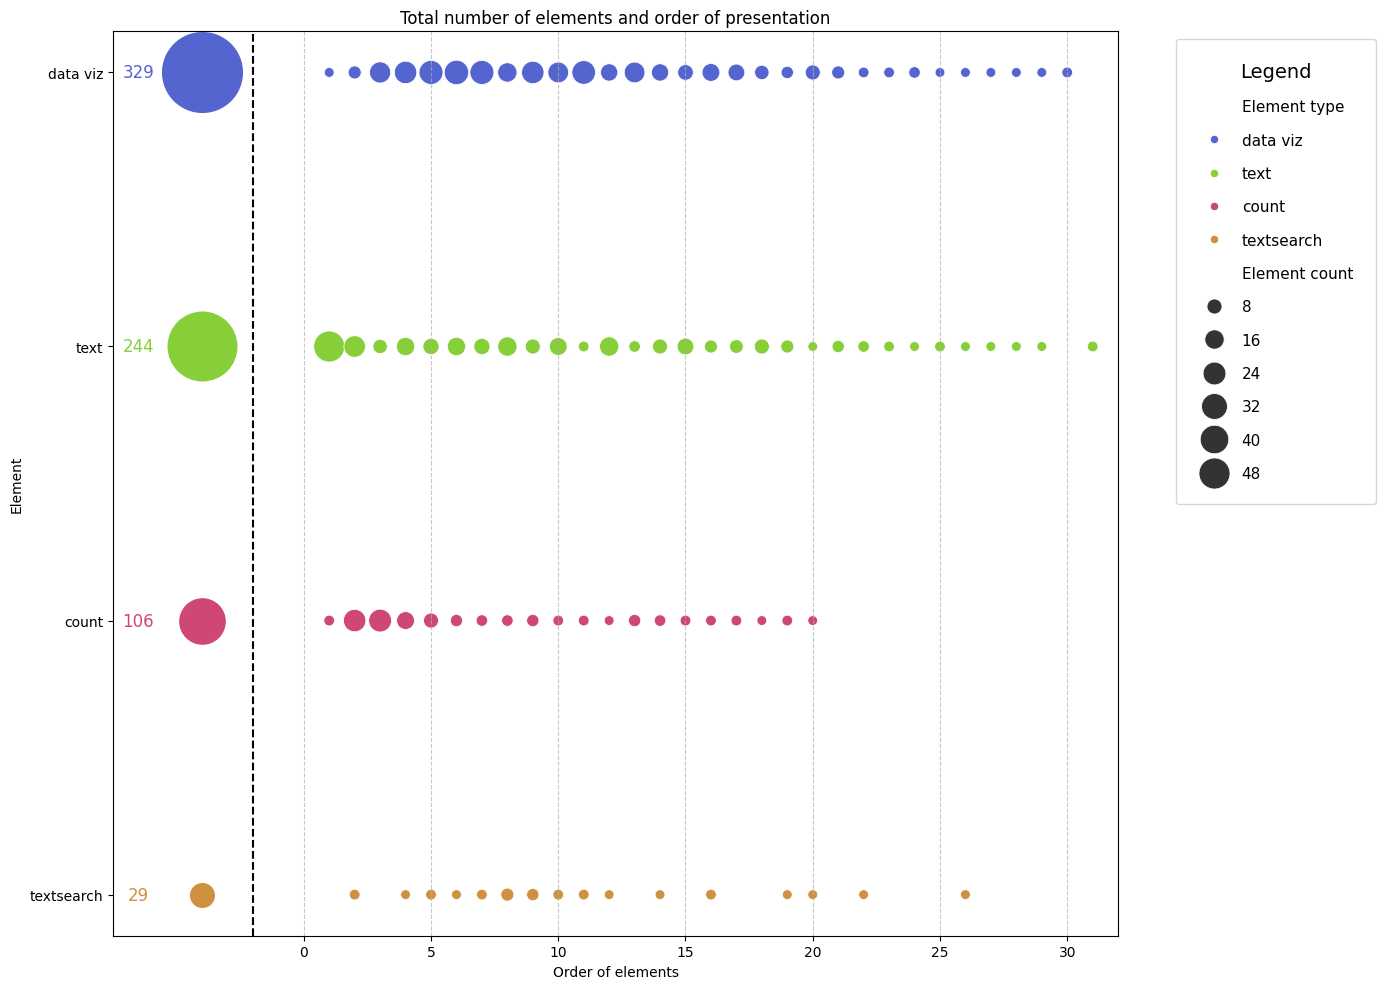

In [159]:
flat_data = []
for story_id, elements in story_elements.items():
    for position, element in elements.items():
        flat_data.append({'Story': story_id, 'Order': int(position), 'Element': element})

# Convert to DataFrame
df = pd.DataFrame(flat_data)

# Aggregate the data
df_agg = df.groupby(['Element', 'Order']).size().reset_index(name='Count')

# Calculate the total occurrences of each element
total_occurrences = df.groupby('Element').size().reset_index(name='Total')

# Sort elements by decreasing total occurrence
total_occurrences = total_occurrences.sort_values(by='Total', ascending=False)

# Merge the total occurrences with the aggregated data
df_final = pd.merge(df_agg, total_occurrences, on='Element')
df_final['Element'] = pd.Categorical(df_final['Element'], categories=total_occurrences['Element'], ordered=True)

# Define a color palette
palette = sns.color_palette([color_palette[0], color_palette[4], color_palette[2], color_palette[3]], len(df_final['Element'].unique()))

# Create a dictionary mapping elements to colors
color_dict = {element: palette[i] for i, element in enumerate(df_final['Element'].cat.categories)}

# Plot the bubble chart
plt.figure(figsize=(14, 10))
scatter_plot = sns.scatterplot(
    data=df_final,
    x='Order', y='Element', size='Count', hue='Element',
    sizes=(50, 500), palette=color_dict, legend='brief'
)

# Adjust positioning of the total occurrences and use the same color as the bubbles
y_positions = total_occurrences['Element']
for i, element in enumerate(y_positions):
    total_value = total_occurrences.loc[total_occurrences['Element'] == element, 'Total'].values[0]
    plt.scatter(-4, element, s=total_value * 10, color=color_dict[element], zorder=5)
    plt.text(-6.5, element, str(total_value), ha='center', va='center', fontsize=12, color=color_dict[element])

# Customize the plot
plt.title('Total number of elements and order of presentation')
plt.xlabel('Order of elements')
plt.ylabel('Element')

# Increase the space on the left to avoid hiding the numbers and bubbles
plt.xlim(-7.5, df_final['Order'].max() + 1)
plt.xticks(ticks=[0, 5, 10, 15, 20, 25, 30])  # Set x-axis ticks starting from 0

plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Add a dashed line separating 'Total' from 'Order of action'
plt.axvline(x=-2, color='black', linestyle='--')

handles, labels = scatter_plot.get_legend_handles_labels()
# Replace 'Element' with 'Element type' and 'Count' with 'Element count'
clean_labels = ['Element type' if label == 'Element' else 'Element count' if label == 'Count' else label for label in labels]

plt.legend(
    handles=handles, labels=clean_labels,
    title='Legend',
    title_fontsize='14',
    fontsize='11',
    bbox_to_anchor=(1.05, 1), loc='upper left',
    labelspacing=1.2,
    borderpad=1.5,
    frameon=True
)

plt.tight_layout()
plt.show()

### Co-occurrences

Binary Matrix: A binary matrix is created where each row corresponds to a story, and each column corresponds to a chart type. The matrix is filled with 1 if a particular chart type is present in the story, and 0 otherwise.

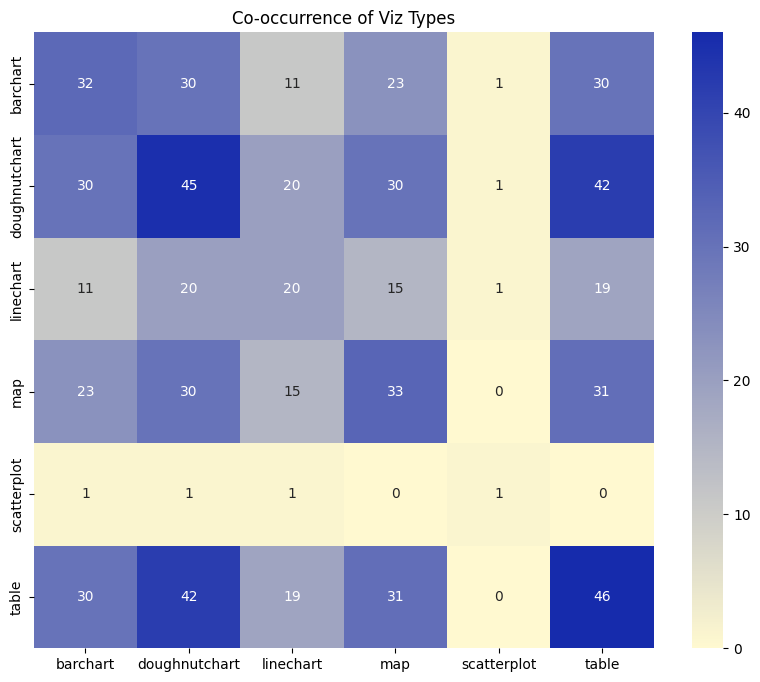

In [2]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract unique chart types across all stories
unique_charts = set()
for story_id, story_data in data.items():
    unique_charts.update(story_data.get('viz_types', []))

unique_charts = sorted(unique_charts)

# Create a binary matrix for chart co-occurrences
chart_matrix = pd.DataFrame(0, index=data.keys(), columns=unique_charts)

for story_id, story_data in data.items():
    for chart in story_data.get('viz_types', []):
        chart_matrix.at[story_id, chart] = 1

# Calculate the co-occurrence matrix
co_occurrence_matrix = np.dot(chart_matrix.T, chart_matrix)

# Convert to DataFrame for better readability
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=unique_charts, columns=unique_charts)

# Define the starting and ending colors
end_color = "#162BAC"
start_color = "#FFF9D0"

# Create a custom colormap from the start to end colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])

# Plotting a heatmap of co-occurrences
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_df, annot=True, cmap=custom_cmap)
plt.title("Co-occurrence of Viz Types")
plt.show()


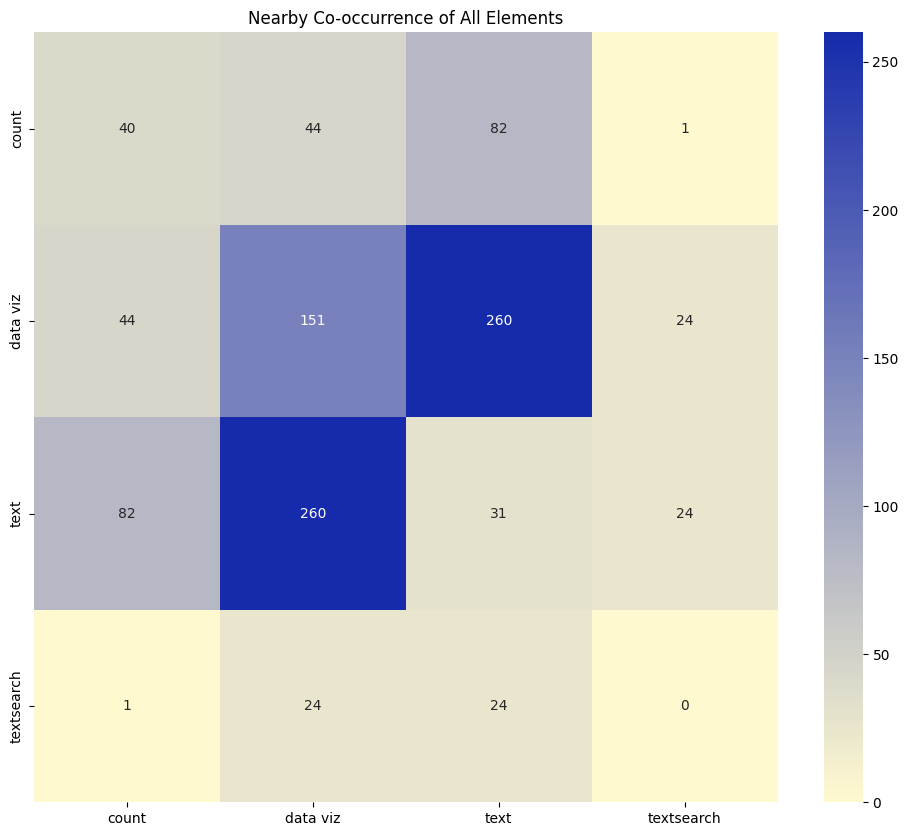

In [8]:
# dictionary to hold pairs of elements that are near each other
nearby_co_occurrences = defaultdict(int)

for story_id, story_data in data.items():
    elements = story_data.get('elements', [])
    
    # Check pairs of elements that are adjacent
    for i in range(len(elements) - 1):
        current_element = elements[i]
        next_element = elements[i + 1]
        pair = tuple(sorted([current_element, next_element]))
        nearby_co_occurrences[pair] += 1

unique_elements = sorted(set([element for pair in nearby_co_occurrences.keys() for element in pair]))
co_occurrence_matrix = pd.DataFrame(0, index=unique_elements, columns=unique_elements)

for (element1, element2), count in nearby_co_occurrences.items():
    co_occurrence_matrix.at[element1, element2] = count
    co_occurrence_matrix.at[element2, element1] = count


plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt=".0f", cmap=custom_cmap)
plt.title("Nearby Co-occurrence of All Elements")
plt.show()



### Text Length

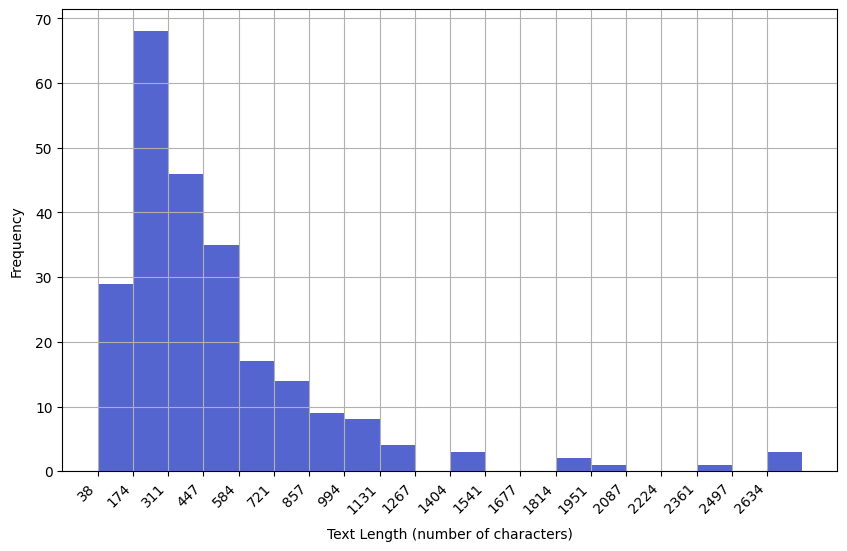

In [20]:
# Extracting text elements and calculating their lengths

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extracting text lengths based on the "texts" key in the dataset
text_lengths = []

# Iterate over each story in the JSON data
for story_id, story_data in data.items():
    texts = story_data.get('texts', [])
    
    # Calculate the length of each text in the list
    for text in texts:
        if len(text) > 0:
            text_lengths.append(len(text))

# Determine the minimum and maximum text length
min_length = min(text_lengths)
max_length = max(text_lengths)

# Reduce the number of bins
num_bins = 20

# Calculate the bin edges (including the rightmost edge)
bin_edges = np.linspace(min_length, max_length, num_bins + 1)

# Visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(text_lengths, bins=num_bins, range=(min_length, max_length), color=color_palette[0])

# Customize the x-axis with simplified labels
# Show a label for every 2nd or 3rd bin to reduce density
bin_labels = [f'{int(bins[i])}' for i in range(len(bins)-1)]
plt.xticks(ticks=bins[:-1], labels=bin_labels, rotation=45, ha='right')


# plt.title('Distribution of Text Lengths in Data Stories')
plt.xlabel('Text Length (number of characters)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.grid(True)

# most texts are short, with a few much longer texts.

{'D-hp3wDV': [1096, 510, 706, 372], 'y4Srva15': [340], '7qpfziir': [564, 207, 74, 81, 302, 190, 359, 378], 'Nokx0yU6': [392], 'gz_gxhYn': [324, 290, 972, 536, 581, 276], 'U2OtB3XT': [253, 462, 155, 210, 741, 334, 500, 264], 'v4h_GSI0': [414, 479], '1ptR3pru': [556], 'JQpdcw-d': [116, 463, 783, 1516, 1865, 632, 1421, 1021, 592], 'B9SLlUry': [645], 'r7i-PG2n': [369, 245, 106, 481, 156, 358, 1928], 'AUmcnOzL': [359, 188, 210, 290], 'tyK82z37': [1054, 266, 510, 175, 236, 456, 785], 'IRRbkmZk': [487, 938, 158, 234, 189], 'Vy4_Rxzv': [342], 'M9EZmoBI': [754, 218, 222, 314, 775, 294, 717, 224, 488, 361, 539, 275], 'uhDaBOl1': [810, 385, 610, 1107, 365], 'SXefpzf4': [], 'EzsIH_Et': [], '16FP4tfG': [671], 'sUMoEZI5': [761, 476, 142, 371, 192, 298, 345], '_HnVHPjm': [211], '4D206Lam': [376, 512, 130, 102], 'j3ZikN40': [269, 1092, 459, 738], 'BOGODrvZ': [225, 136, 219, 190, 70, 310, 386, 280, 791, 75, 2037], 'abkhtH-r': [473, 779], 'Huo1mZpJ': [449, 85, 94, 110, 316, 252, 170, 485, 271, 204, 350]

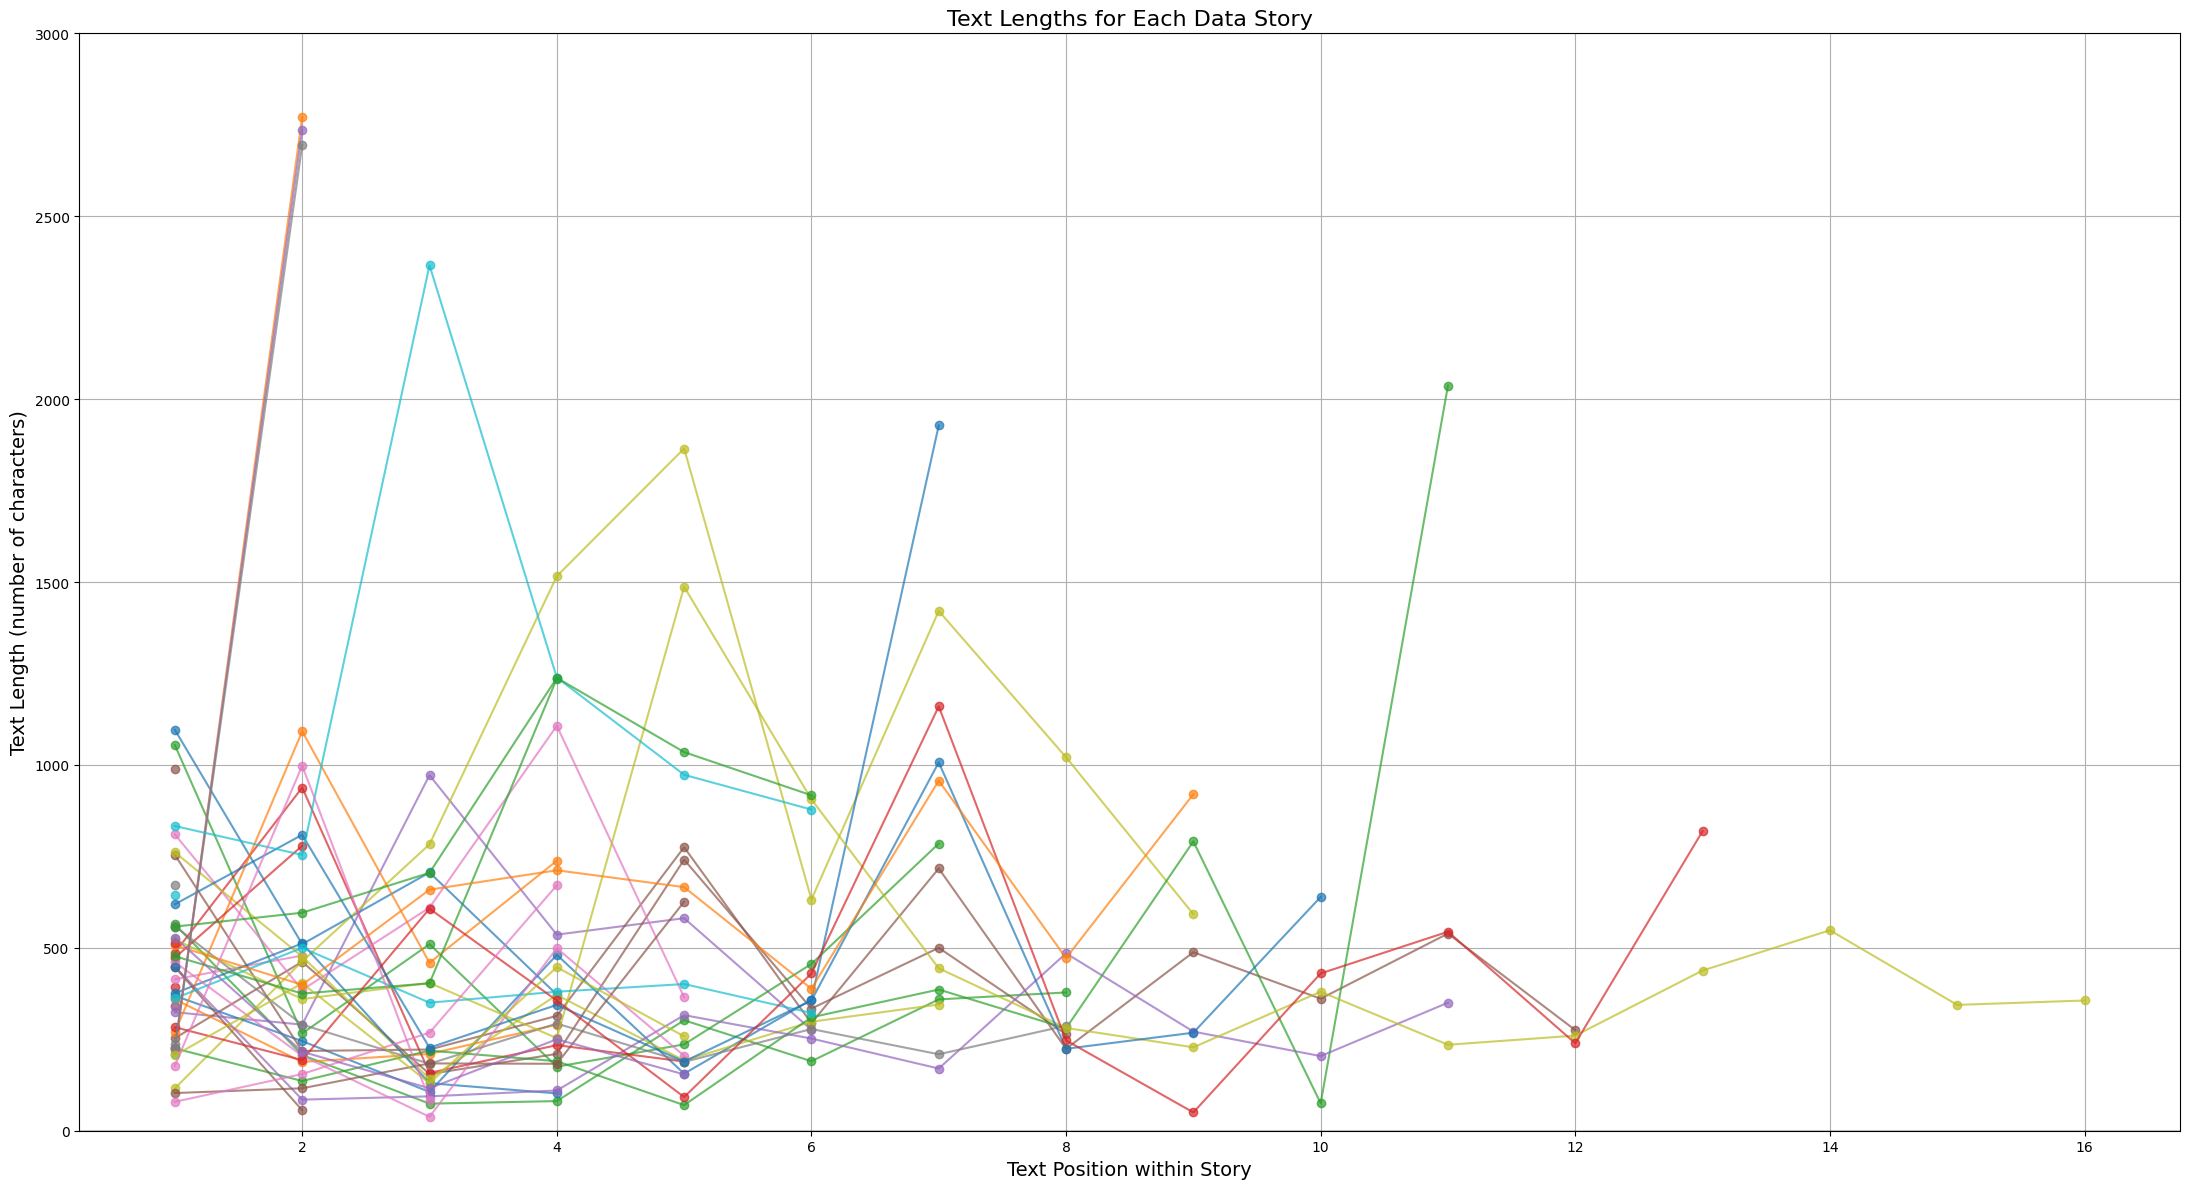

In [39]:
text_lengths_per_story = {}

# Iterate over each story in the JSON data
for story_id, story_data in data.items():
    texts = story_data.get('texts', [])
    
    # Collect lengths for each text in the story
    text_lengths_per_story[story_id] = [len(text) for text in texts if len(text) > 0]

print(text_lengths_per_story)

# Plot the line chart
plt.figure(figsize=(22, 12))  # Enlarging the plot (width=18, height=12)

# Plot each story's text lengths as a separate line with alpha for transparency
for story_id, lengths in text_lengths_per_story.items():
    if len(lengths) > 0:
        plt.plot(range(1, len(lengths) + 1), lengths, marker='o', alpha=0.7)  # Removed label to hide legend

# Customize the plot
plt.title('Text Lengths for Each Data Story', fontsize=16)
plt.xlabel('Text Position within Story', fontsize=14)
plt.ylabel('Text Length (number of characters)', fontsize=14)

# Set y-axis limit with a max value of 3000 for better separation
plt.ylim(0, 3000)

# Customize the grid and set axes
plt.grid(True)
plt.axhline(0, color='black', linewidth=1.0)  # X-axis at y=0

# Remove the legend
# plt.legend() is omitted to avoid showing the legend

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

{'D-hp3wDV': [1096, 510, 706, 372], 'y4Srva15': [340], '7qpfziir': [564, 207, 74, 81, 302, 190, 359, 378], 'Nokx0yU6': [392], 'gz_gxhYn': [324, 290, 972, 536, 581, 276], 'U2OtB3XT': [253, 462, 155, 210, 741, 334, 500, 264], 'v4h_GSI0': [414, 479], '1ptR3pru': [556], 'JQpdcw-d': [116, 463, 783, 1516, 1865, 632, 1421, 1021, 592], 'B9SLlUry': [645], 'r7i-PG2n': [369, 245, 106, 481, 156, 358, 1928], 'AUmcnOzL': [359, 188, 210, 290], 'tyK82z37': [1054, 266, 510, 175, 236, 456, 785], 'IRRbkmZk': [487, 938, 158, 234, 189], 'Vy4_Rxzv': [342], 'M9EZmoBI': [754, 218, 222, 314, 775, 294, 717, 224, 488, 361, 539, 275], 'uhDaBOl1': [810, 385, 610, 1107, 365], 'SXefpzf4': [], 'EzsIH_Et': [], '16FP4tfG': [671], 'sUMoEZI5': [761, 476, 142, 371, 192, 298, 345], '_HnVHPjm': [211], '4D206Lam': [376, 512, 130, 102], 'j3ZikN40': [269, 1092, 459, 738], 'BOGODrvZ': [225, 136, 219, 190, 70, 310, 386, 280, 791, 75, 2037], 'abkhtH-r': [473, 779], 'Huo1mZpJ': [449, 85, 94, 110, 316, 252, 170, 485, 271, 204, 350]

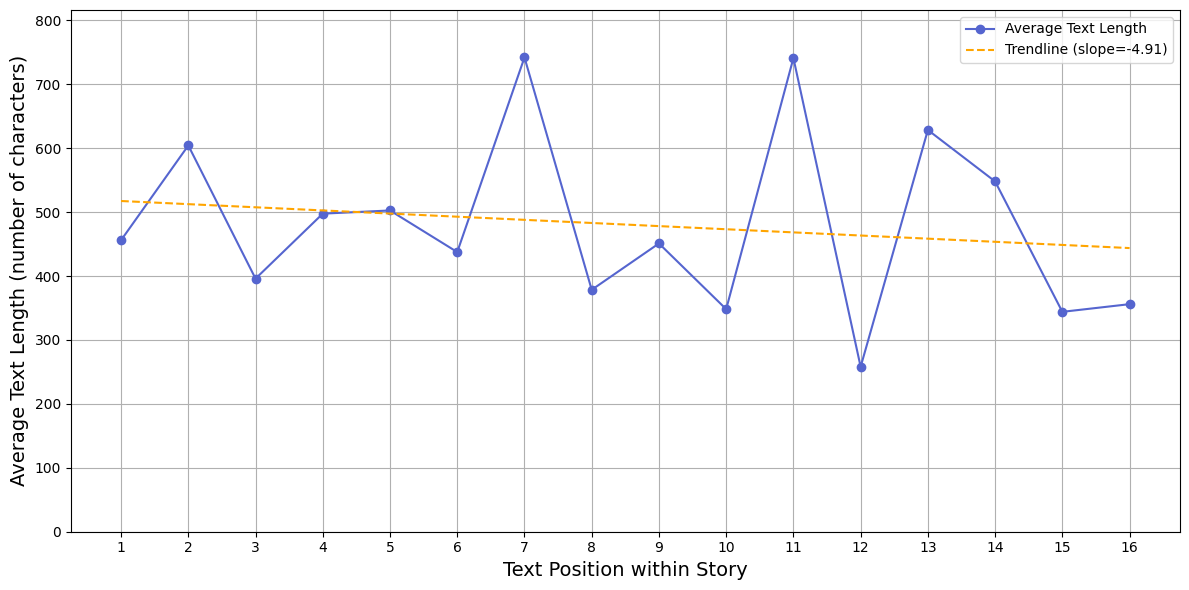

In [15]:
text_lengths_per_story = {}

# Iterate over each story in the JSON data
for story_id, story_data in data.items():
    texts = story_data.get('texts', [])
    
    # Collect lengths for each text in the story
    text_lengths_per_story[story_id] = [len(text) for text in texts if len(text) > 0]

print(text_lengths_per_story)

# Determine the maximum story length
max_story_length = max(len(lengths) for lengths in text_lengths_per_story.values())

# Initialize a list to store average text lengths for each position
average_lengths = []
for position in range(max_story_length):
    # Collect text lengths at the current position across all stories
    lengths_at_position = [lengths[position] for lengths in text_lengths_per_story.values() if len(lengths) > position]
    # Calculate the average length (or use 0 if there are no lengths at this position)
    avg_length = np.mean(lengths_at_position) if lengths_at_position else 0
    average_lengths.append(avg_length)

# Fit a 1st-degree polynomial (linear regression) to detect the trend
x = np.arange(1, len(average_lengths) + 1)
coeffs = np.polyfit(x, average_lengths, deg=1)
trendline = np.polyval(coeffs, x)

# Plot the average line with a trendline
plt.figure(figsize=(12, 6))
plt.plot(x, average_lengths, marker='o', linestyle='-', color=color_palette[0], label='Average Text Length')
plt.plot(x, trendline, linestyle='--', color='orange', label=f'Trendline (slope={coeffs[0]:.2f})')
plt.xticks(ticks=x, labels=x) 

# Add labels, title, and grid
plt.xlabel('Text Position within Story', fontsize=14)
plt.ylabel('Average Text Length (number of characters)', fontsize=14)
plt.ylim(0, max(average_lengths) * 1.1)  # Add some space above the maximum
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Number of stories with closing text: 12


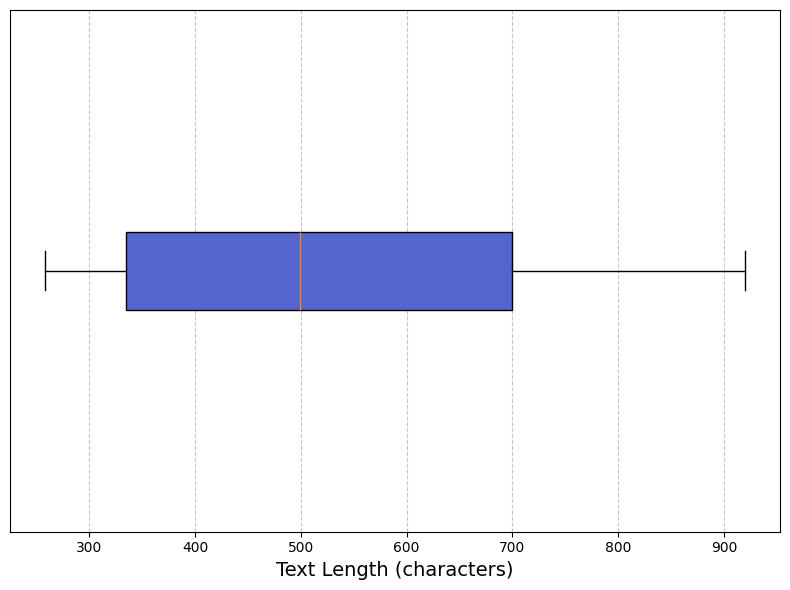

In [38]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Iterate through each story in the data
final_text_lengths = []  # Store lengths of the last 'text' elements
for story_id, story_data in data.items():
    # Get the 'elements_order' dictionary
    elements_order = story_data.get('elements_order', {})
    elements = story_data.get('elements', [])

    # Get the last element's key and value
    last_element_value = elements_order[str(len(elements_order))]

    # Check if the last element is "text"
    if last_element_value == "text":
        texts = story_data.get('texts', [])
        last_text = texts[-1]
        final_text_lengths.append(len(last_text))
print(f'Number of stories with closing text: {len(final_text_lengths)}')

# Plot the final text lengths if needed
plt.figure(figsize=(8, 6))
plt.boxplot(final_text_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor=color_palette[0]))
plt.xlabel("Text Length (characters)", fontsize=14)
plt.yticks([])

plt.grid(axis='x', linestyle="--", alpha=0.7) 

plt.tight_layout()
plt.show()



Number of stories with closing text: 12


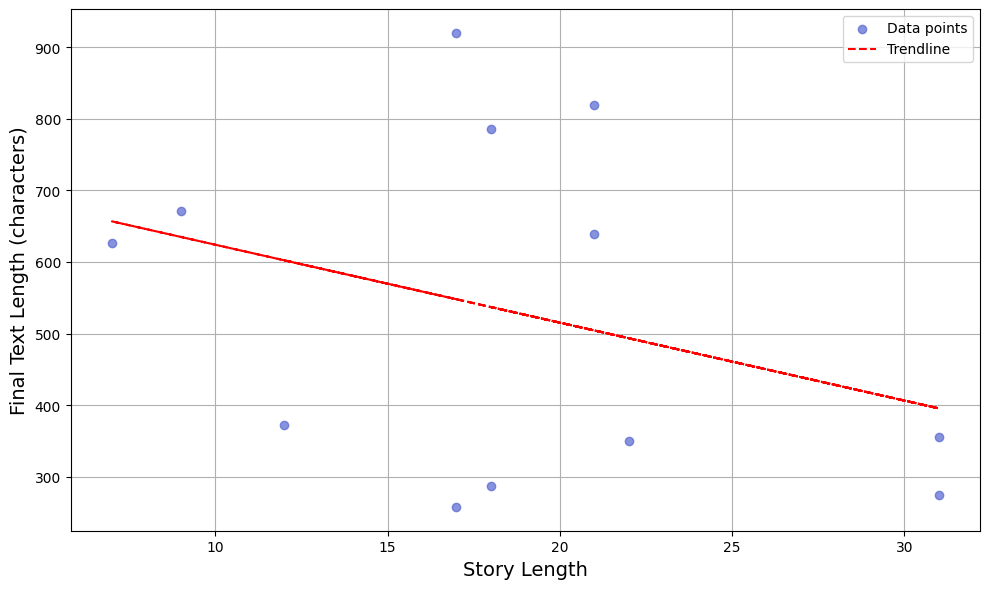

In [31]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Iterate through each story in the data
story_lengths = []
final_text_lengths = []  # Store lengths of the last 'text' elements

for story_id, story_data in data.items():
    # Get the 'elements_order' dictionary
    elements_order = story_data.get('elements_order', {})

    # Get the last element's key and value
    last_element_value = elements_order[str(len(elements_order))]

    # Check if the last element is "text"
    if last_element_value == "text":
        texts = story_data.get('texts', [])
        last_text = texts[-1]
        final_text_lengths.append(len(last_text))
        story_lengths.append(len(elements_order))
print(f'Number of stories with closing text: {len(final_text_lengths)}')

coeffs = np.polyfit(story_lengths, final_text_lengths, 1)  # Linear regression
trendline = np.polyval(coeffs, story_lengths)

# Plot scatter with trendline
plt.figure(figsize=(10, 6))
plt.scatter(story_lengths, final_text_lengths, color=color_palette[0], alpha=0.7, label="Data points")
plt.plot(story_lengths, trendline, color="red", linestyle="--", label="Trendline")

plt.xlabel("Story Length", fontsize=14)
plt.ylabel("Final Text Length (characters)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Data Story Quality Score

Computes a quality score for a single data story based on:
1. Text ratio in a target range (45%-55%).
2. No more than 3 consecutive chart-like components.

In [2]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

story_elements = {}

for story_id, story_data in data.items():
    story_elements[story_id] = story_data['elements_order']

df_quality = pd.DataFrame()

for story, elements in story_elements.items():
    temp_df = pd.DataFrame.from_dict(elements, orient='index', columns=[story])
    temp_df = temp_df.T
    df_quality = pd.concat([df_quality, temp_df], sort=False)
print(df_quality)

                 1           2         3           4           5           6  \
D-hp3wDV      text       count     count    data viz    data viz    data viz   
y4Srva15      text       count  data viz    data viz    data viz    data viz   
7qpfziir      text        text     count       count       count        text   
Nokx0yU6      text  textsearch  data viz    data viz         NaN         NaN   
gz_gxhYn      text       count     count       count        text    data viz   
U2OtB3XT      text        text     count        text       count        text   
v4h_GSI0      text       count  data viz    data viz        text    data viz   
1ptR3pru      text       count     count    data viz    data viz    data viz   
JQpdcw-d      text        text     count       count    data viz    data viz   
B9SLlUry      text       count     count    data viz    data viz    data viz   
r7i-PG2n      text        text     count       count        text    data viz   
AUmcnOzL      text       count      text

In [ ]:
def compute_quality_score(row,
                          text=['text'],
                          viz_types=['data viz'],
                          text_ratio_range=(0.40, 0.60),
                          weight_text=0.5,
                          weight_viz=0.5):
    components = row.dropna().tolist()
    if not components:
        return 0.0
    
    total = len(components)
    n_text = sum(1 for comp in components if comp in text)
    text_ratio = n_text / total

    #text
    if text_ratio_range[0] <= text_ratio <= text_ratio_range[1]:
        text_ratio_metric = 1.0
    else:
        text_ratio_metric = 0.0
    
    # data viz
    consecutive_count = 0
    excess_viz = 0

    for comp in components:
        if comp in viz_types:
            consecutive_count +=1
        else:
            # when a sequence of charts ends, count any excess beyond 3
            if consecutive_count > 3:
                excess_viz += (consecutive_count - 3)
            consecutive_count = 0
    if consecutive_count > 3:
        excess_viz += (consecutive_count - 3)

    repetitiveness_penalty = min(1.0, excess_viz/total)
    viz_repetitiveness_metric = 1.0 - repetitiveness_penalty
    print(text_ratio_metric)
    # combine the two metrics
    quality_score = (weight_text * text_ratio_metric) + (weight_viz * viz_repetitiveness_metric)
    return round(quality_score, 2)

df_quality['quality_score'] = df_quality.apply(compute_quality_score, axis=1)
print(df_quality[['quality_score']])
df_quality[['quality_score']].to_csv('quality_score_one.csv')

0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
          quality_score
D-hp3wDV           0.50
y4Srva15           0.43
7qpfziir           1.00
Nokx0yU6           0.50
gz_gxhYn           0.50
U2OtB3XT           1.00
v4h_GSI0           0.50
1ptR3pru           0.32
JQpdcw-d           1.00
B9SLlUry           0.40
r7i-PG2n           1.00
AUmcnOzL           0.50
tyK82z37           0.50
IRRbkmZk           0.50
Vy4_Rxzv           0.44
M9EZmoBI           0.50
uhDaBOl1           0.47
SXefpzf4           0.50
EzsIH_Et           0.44
16FP4tfG           0.43
sUMoEZI5           0.48
_HnVHPjm           0.50
4D206Lam           0.40
j3ZikN40           0.50
BOGODrvZ           1.00
abkhtH-r           0.31
Huo1mZpJ           1.00
JYOzBt8Y           0.38
buiNjeJj           0.43
PziKYGG_           1.00
wa1_2kB_           1.00
lkuzAhad           0.47
jamF

In [16]:
def compute_quality_score(row,
                          text=['text'],
                          viz_types=['data viz'],
                          text_ratio_range=(0.40, 0.60),
                          weight_text=0.5,
                          weight_viz=0.5):
    components = row.dropna().tolist()
    if not components:
        return 0.0
    
    total = len(components)
    n_text = sum(1 for comp in components if comp in text)
    text_ratio = n_text / total

    #text
    if text_ratio <= 0.40:
        text_ratio_metric = 0.0
    elif text_ratio <= 0.60:
        text_ratio_metric = (text_ratio - 0.40) / (0.60 - 0.40)
    elif text_ratio <= 1.0:
        text_ratio_metric = (1.0 - text_ratio) / (1.0 - 0.60)
    else:
        # If somehow text_ratio exceeds 1.0, assign 0.
        text_ratio_metric = 0.0
    
    # data viz
    consecutive_count = 0
    excess_viz = 0

    for comp in components:
        if comp in viz_types:
            consecutive_count +=1
        else:
            # when a sequence of charts ends, count any excess beyond 3
            if consecutive_count > 3:
                excess_viz += (consecutive_count - 3)
            consecutive_count = 0
    if consecutive_count > 3:
        excess_viz += (consecutive_count - 3)

    repetitiveness_penalty = min(1.0, excess_viz/total)
    viz_repetitiveness_metric = 1.0 - repetitiveness_penalty
    print(text_ratio_metric)
    # combine the two metrics
    quality_score = (weight_text * text_ratio_metric) + (weight_viz * viz_repetitiveness_metric)
    return round(quality_score, 2)

df_quality['quality_score'] = df_quality.apply(compute_quality_score, axis=1)
print(df_quality[['quality_score']])
df_quality[['quality_score']].to_csv('quality_score_two.csv')

0.0
0.0
0.0
0.0
0.0
0.35294117647058815
0.0
0.0
0.04545454545454548
0.0
0.05882352941176451
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03703703703703682
0.0
0.39130434782608703
0.0
0.0
0.10526315789473664
0.5
0.0
0.2727272727272726
0.0
0.0
0.9545454545454548
0.0
0.9375
0.0
0.0
0.0
0.0
0.0
0.5
0.14285714285714265
0.0
0.0
0.0
0.0
0.0
0.0
          quality_score
D-hp3wDV           0.50
y4Srva15           0.43
7qpfziir           0.50
Nokx0yU6           0.50
gz_gxhYn           0.50
U2OtB3XT           0.68
v4h_GSI0           0.50
1ptR3pru           0.32
JQpdcw-d           0.52
B9SLlUry           0.40
r7i-PG2n           0.53
AUmcnOzL           0.50
tyK82z37           0.50
IRRbkmZk           0.50
Vy4_Rxzv           0.44
M9EZmoBI           0.50
uhDaBOl1           0.47
SXefpzf4           0.50
EzsIH_Et           0.44
16FP4tfG           0.43
sUMoEZI5           0.48
_HnVHPjm           0.50
4D206Lam           0.40
j3ZikN40           0.50
BOGODrvZ           0.52
abkhtH-r           0.31
Huo

## Queries

In [ ]:
# Define expected rules based on query type
expected_variables_by_type = {
    'table': None,  # No constraints on variable names, labels can be used
    'count': ['count'],  # Must have ?count of type number
    'barchart': ['label', 'count'],  # Option 1: ?label and ?count, Option 2: only ?label
    'linechart': ['label', 'count'],
    'doughnutchart': ['label', 'count'],
    'scatterplot': ['x', 'y'],  # Must have ?x and ?y
    'textsearch': None,  # No specific constraints, <<searchterm>> placeholder is normal
    'map': ['point', 'lat', 'long']  # Must have ?point, ?lat, and ?long
}

# Function to test the SPARQL query and validate based on type
def test_sparql_query(endpoint, query, default_search_term='"example_search_term"', max_retries=3, delay=30):
    headers = {
        'Accept': 'application/sparql-results+json'
    }

    # Replace the placeholder <<searchterm>> with the default search term
    query = query.replace("<<searchterm>>", default_search_term)

    params = {
        'query': query
    }
    
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(endpoint, headers=headers, params=params)
            
            # Check for any 2xx status code (successful responses)
            if 200 <= response.status_code < 300:
                print(f"Query to {endpoint} succeeded with status code {response.status_code}.")
                
                # Attempt to parse the JSON response
                try:
                    response_json = response.json()  # Ensure the response is valid JSON
                    return True, response_json
                except json.JSONDecodeError:
                    print(f"Failed to parse JSON for {query}. Response content: {response.text}")
                    return True, None  # Consider it a successful query but with invalid JSON
                
            elif response.status_code == 429:
                print(f'Rate limit hit (429). Retrying in {delay} seconds...')
                time.sleep(delay)
                retries += 1
            else:
                print(f'{response.status_code} for {endpoint}, {query}')
                return False, None
        except Exception as e:
            print(f'Exception for {endpoint}, {query}: {e}')
            return False, None
    return False, None

# Function to check for query correctness based on result variables and type-specific rules
def check_query_correctness(response_json, query_type):
    # If the response_json is None, we cannot validate the correctness
    if response_json is None:
        print(f"No valid JSON to check for query type {query_type}.")
        return False
    
    # Handling each type of query based on specific rules
    if query_type == 'table':
        print("Checking table query")
        return True
    
    elif query_type == 'count':
        print("Checking count query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'count' in returned_vars:
                # Now check if the count is a number
                if 'results' in response_json and 'bindings' in response_json['results']:
                    for binding in response_json['results']['bindings']:
                        if 'count' in binding and binding['count']['type'] == 'literal' and binding['count'].get('datatype') == 'http://www.w3.org/2001/XMLSchema#integer':
                            return True
                print(f"Query did not return a valid number for ?count")
        return False

    elif query_type in ['barchart', 'linechart', 'doughnutchart']:
        print(f"Checking {query_type} query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if ('label' in returned_vars and 'count' in returned_vars) or ('label' in returned_vars):
                return True
        return False
    
    elif query_type == 'scatterplot':
        print("Checking scatterplot query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'x' in returned_vars and 'y' in returned_vars:
                return True
        return False

    elif query_type == 'textsearch':
        print("Checking textsearch query")
        return True  # Assume correctness as the search term is dynamically replaced
    
    elif query_type == 'map':
        print("Checking map query")
        if 'head' in response_json and 'vars' in response_json['head']:
            returned_vars = response_json['head']['vars']
            if 'point' in returned_vars and 'lat' in returned_vars and 'long' in returned_vars:
                return True
        return False

    else:
        print(f"Unrecognized query type: {query_type}")
        return False

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

story_sparql_metrics = []

# Iterate over the stories in the JSON
for story_id, story in data.items():
    sparql_endpoint = story['sparql_endpoint']
    queries = story.get('queries', [])

    total_queries = 0
    working_queries = 0
    correct_queries = 0

    for query_dict in queries:
        query = query_dict.get('query', '')
        query_type = query_dict.get('type', '')
        total_queries += 1
        query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
        query = re.sub(r'\s+', ' ', query).strip()

        success, response_json = test_sparql_query(sparql_endpoint, query)
        
        if success:
            working_queries += 1
            # Check query correctness based on response variables and result content
            if response_json:
                if check_query_correctness(response_json, query_type):
                    correct_queries += 1
        # Delay of 5 seconds between queries to avoid hitting rate limits
        time.sleep(5)

    # Calculate the percentage of working queries
    if total_queries > 0:
        working_percentage = (working_queries / total_queries) * 100
        correct_percentage = (correct_queries / total_queries) * 100
    else:
        working_percentage = 0
        correct_percentage = 0
    
    # composite SPARQL proficiency score (normalized to [0, 1]
    proficiency_score = (working_percentage + correct_percentage) / 200.0
    story_sparql_metrics.append({
        'story_id': story_id,
        'total_queries': total_queries,
        'working_queries': working_queries,
        'correct_queries': correct_queries,
        'working_percentage': working_percentage,
        'correct_percentage': correct_percentage,
        'sparql_proficiency': round(proficiency_score, 2)
    })

    print(f"Story ID: {story_id} | Total: {total_queries} | Working: {working_queries} "
          f"({working_percentage:.2f}%) | Correct: {correct_queries} ({correct_percentage:.2f}%) | "
          f"Proficiency: {proficiency_score:.2f}")

df_sparql = pd.DataFrame(story_sparql_metrics)
# df_overall_quality = df_quality.merge(df_sparql[['story_id', 'sparql_proficiency']], on='story_id', how='left')


# labels = ['Working Queries', 'Failed Queries']
# sizes = [working_queries, total_queries - working_queries]
# plt.figure(figsize=(6, 6))
# plt.pie(sizes, labels=labels, colors=[color_palette[5],color_palette[1]], autopct='%1.1f%%', startangle=90)  # autopct used to display the percentage of each segment on the pie chart
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('Percentage of Working SPARQL Queries')
# plt.show()

# # Visualization for correct queries
# labels = ['Correct Queries', 'Incorrect Queries']
# sizes = [correct_queries, total_queries - correct_queries]
# plt.figure(figsize=(6, 6))
# plt.pie(sizes, labels=labels, colors=[color_palette[5],color_palette[1]], autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.title('Percentage of Correct SPARQL Queries')
# plt.show()

Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking count query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking count query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking barchart query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking doughnutchart query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking table query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking table query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking table query
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking table query
Story ID: D-hp3wDV | Total: 8 | Working: 8 (100.00%) | Correct: 8 (100.00%) | Proficiency: 1.00
Query to https://query.wikidata.org/sparql succeeded with status code 200.
Checking count query
Query to https://query.wikida

KeyError: 'story_id'

In [42]:
# df_quality = df_quality.reset_index().rename(columns={'index': 'story_id'})
# df_overall_quality = df_quality.merge(df_sparql[['story_id', 'sparql_proficiency']], on='story_id', how='left')
# df_overall_quality

In [45]:
df_sparql_proficiency = df_sparql.drop(columns=['sparql_proficiency'])
df_sparql_proficiency

,story_id,total_queries,working_queries,correct_queries,working_percentage,correct_percentage
0,D-hp3wDV,8,8,8,100.000000,100.000000
1,y4Srva15,5,5,5,100.000000,100.000000
2,7qpfziir,11,11,11,100.000000,100.000000
3,Nokx0yU6,3,3,3,100.000000,100.000000
4,gz_gxhYn,11,11,11,100.000000,100.000000
5,U2OtB3XT,8,8,8,100.000000,100.000000
6,v4h_GSI0,4,4,4,100.000000,100.000000
7,1ptR3pru,9,9,9,100.000000,100.000000
8,JQpdcw-d,12,12,12,100.000000,100.000000
9,B9SLlUry,8,8,8,100.000000,100.000000


In [31]:
# for idx, row in df_sparql.iterrows():
#     story_id = row['story_id']
#     total = row['total_queries']
#     working = row['working_queries']
#     correct = row['correct_queries']

#     # Plot pie chart for Working Queries
#     labels = ['Working Queries', 'Failed Queries']
#     sizes = [working, total - working]
#     plt.figure(figsize=(6, 6))
#     plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
#     plt.axis('equal')
#     plt.title(f'Story {story_id}: Percentage of Working SPARQL Queries')
#     plt.show()

#     # Plot pie chart for Correct Queries
#     labels = ['Correct Queries', 'Incorrect Queries']
#     sizes = [correct, total - correct]
#     plt.figure(figsize=(6, 6))
#     plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
#     plt.axis('equal')
#     plt.title(f'Story {story_id}: Percentage of Correct SPARQL Queries')
#     plt.show()

In [7]:
print(total_queries - working_queries)

300


Total Queries: 464
Federated Queries: 26
Percentage of Queries using Federated Endpoints: 5.60%

Federated Endpoint Usage Frequency:
                                Federated Endpoint  Count
0  query.wikidata.org/bigdata/namespace/wdq/sparql     23
1                               dbpedia.org/sparql      2
2                       dati.cultura.gov.it/sparql      1


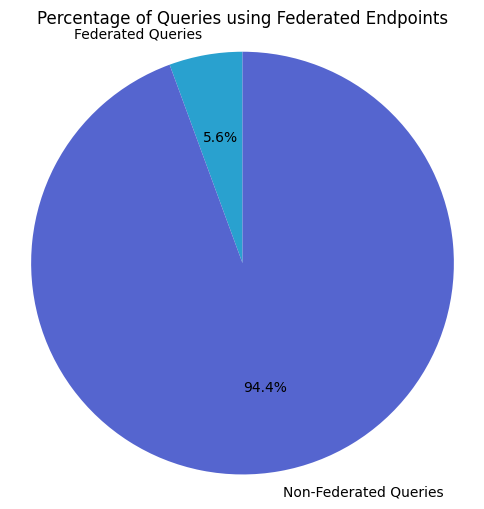

In [204]:
# Federated queries

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    
# Regular expression to capture all federated endpoints in SERVICE clauses
service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

# Initialize counters
total_queries = 0
federated_queries = 0
federated_endpoints = []

# Loop through the stories in the JSON data
for story_id, story_data in data.items():
    # Get the queries for the story
    queries = story_data.get('queries', [])
    
    # Get the main SPARQL endpoint of the story (keeping the part after //)
    main_endpoint = story_data.get("sparql_endpoint", "")
    if main_endpoint:
        data_sources_list.append(main_endpoint.split("//")[1])  # Keep everything after the //

    # Loop through each query
    for query_dict in queries:
        total_queries += 1  # Increment total query count
        query = query_dict.get('query', '')
        
        # Find all SERVICE matches (for federated queries)
        service_matches = service_pattern.findall(query)
        
        # If SERVICE matches are found, this is a federated query
        if service_matches:
            federated_queries += 1  # Increment federated query count
            federated_endpoints.extend([service_url.split("//")[1] for service_url in service_matches])  # Keep the part after //

# Calculate percentage of federated queries
if total_queries > 0:
    percentage_federated = (federated_queries / total_queries) * 100
else:
    percentage_federated = 0

# Print the summary
print(f"Total Queries: {total_queries}")
print(f"Federated Queries: {federated_queries}")
print(f"Percentage of Queries using Federated Endpoints: {percentage_federated:.2f}%")

# Analyze federated endpoint usage
federated_endpoints_counter = Counter(federated_endpoints)
federated_endpoints_df = pd.DataFrame(federated_endpoints_counter.items(), columns=["Federated Endpoint", "Count"])

print("\nFederated Endpoint Usage Frequency:")
print(federated_endpoints_df)

labels = ['Federated Queries', 'Non-Federated Queries']
sizes = [federated_queries, total_queries - federated_queries]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=[color_palette[6],color_palette[0]])
plt.axis('equal')
plt.title('Percentage of Queries using Federated Endpoints')
plt.show()

In [36]:
file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    
# Regular expression to capture all federated endpoints in SERVICE clauses
service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

# Initialize counters
federation_metrics = []
data_sources_list = []

# Loop through the stories in the JSON data (per story)
for story_id, story_data in data.items():
    queries = story_data.get('queries', [])
    
    main_endpoint = story_data.get("sparql_endpoint", "")
    if main_endpoint:
        data_sources_list.append(main_endpoint.split("//")[1])
    
    total_queries_story = 0
    federated_queries_story = 0
    
    # Loop through each query in the story
    for query_dict in queries:
        total_queries_story += 1
        query = query_dict.get('query', '')
        
        service_matches = service_pattern.findall(query)
        if service_matches:
            federated_queries_story += 1
    
    # Calculate federated bonus for this story (fraction of federated queries)
    federated_bonus = (federated_queries_story / total_queries_story) if total_queries_story > 0 else 0
    
    # Store per-story federation metrics (using story_id as key)
    federation_metrics.append({
        'story_id': story_id,
        'total_queries_story': total_queries_story,
        'federated_queries_story': federated_queries_story,
        'federated_bonus': round(federated_bonus, 2)
    })

# (Optional) Create a DataFrame to inspect federation metrics per story
df_federation = pd.DataFrame(federation_metrics)
print(df_federation[['story_id', 'federated_bonus']])

    story_id  federated_bonus
0   D-hp3wDV             0.00
1   y4Srva15             0.00
2   7qpfziir             0.00
3   Nokx0yU6             0.00
4   gz_gxhYn             0.00
5   U2OtB3XT             0.00
6   v4h_GSI0             0.00
7   1ptR3pru             0.00
8   JQpdcw-d             0.00
9   B9SLlUry             0.00
10  r7i-PG2n             0.56
11  AUmcnOzL             0.00
12  tyK82z37             0.00
13  IRRbkmZk             0.00
14  Vy4_Rxzv             0.00
15  M9EZmoBI             0.00
16  uhDaBOl1             0.00
17  SXefpzf4             0.00
18  EzsIH_Et             0.00
19  16FP4tfG             0.00
20  sUMoEZI5             0.00
21  _HnVHPjm             0.00
22  4D206Lam             0.00
23  j3ZikN40             0.00
24  BOGODrvZ             0.80
25  abkhtH-r             0.00
26  Huo1mZpJ             0.00
27  JYOzBt8Y             0.00
28  buiNjeJj             0.00
29  PziKYGG_             0.00
30  wa1_2kB_             0.00
31  lkuzAhad             0.00
32  jamFJt

In [ ]:
# federated_weight = 0.2  # 20% weight for federated bonus

# Merge the federated bonus into df_sparql
df_sparql_proficiency = df_sparql_proficiency.merge(df_federation[['story_id', 'federated_bonus']], on='story_id', how='left')

# # new_proficiency = original_proficiency*(1 - federated_weight) + federated_bonus*federated_weight
# df_sparql_updated['sparql_proficiency'] = df_sparql_updated.apply(
#     lambda row: round(row['sparql_proficiency'] * (1 - federated_weight) + row['federated_bonus'] * federated_weight, 2),
#     axis=1
# )

print(df_sparql_proficiency)

    story_id  total_queries  working_queries  correct_queries  \
0   D-hp3wDV              8                8                8   
1   y4Srva15              5                5                5   
2   7qpfziir             11               11               11   
3   Nokx0yU6              3                3                3   
4   gz_gxhYn             11               11               11   
5   U2OtB3XT              8                8                8   
6   v4h_GSI0              4                4                4   
7   1ptR3pru              9                9                9   
8   JQpdcw-d             12               12               12   
9   B9SLlUry              8                8                8   
10  r7i-PG2n              9                8                8   
11  AUmcnOzL              6                6                5   
12  tyK82z37             11               11                9   
13  IRRbkmZk              8                8                7   
14  Vy4_Rxzv             

SELECT DISTINCT ?point ?pointLabel ?villeIdLabel ?lat ?long WHERE { { ?point wdt:P31 wd:Q215380; wdt:P495 wd:Q38; wdt:P136/wdt:P279* wd:Q11399; wdt:P740 ?villeId. ?villeId wdt:P131 ?province. ?province wdt:P131 wd:Q1263. } UNION { ?point wdt:P106/wdt:P279* wd:Q177220; wdt:P19 ?villeId; wdt:P136 wd:Q11399. ?villeId wdt:P131 ?province. ?province wdt:P131 wd:Q1263. } ?villeId p:P625 ?statement. ?statement psv:P625 ?node. ?node wikibase:geoLatitude ?lat. ?node wikibase:geoLongitude ?long. SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } }
Counter({2: 103, 4: 74, 5: 61, 1: 57, 3: 55, 6: 28, 8: 22, 7: 20, 11: 13, 10: 8, 9: 6, 0: 6, 14: 4, 12: 3, 13: 3, 16: 1})


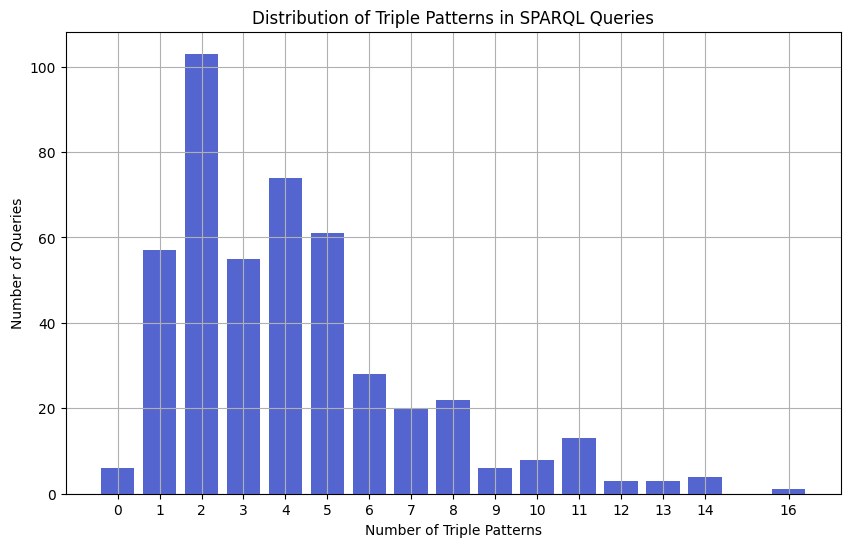

In [3]:
# TODO: IN ORDER TO CHECK CORRECTNESS, CREATE A DICTIONARY (QUERY,TRIPLES_LIST)
# TODO: tranform y in %
def extract_where_clause(query):
    start = query.find('WHERE')
    if start == -1:
        return None

    # Find the opening brace
    start = query.find('{', start)
    if start == -1:
        return None

    # Use a stack to find the matching closing brace
    stack = []
    for i in range(start, len(query)):
        if query[i] == '{':
            stack.append('{')
        elif query[i] == '}':
            stack.pop()
            if not stack:
                return query[start + 1:i]  # Return the content between the outermost braces

    return None  # In case the braces are unbalanced

def count_triple_patterns(query):
    where_clause = extract_where_clause(query)
    
    if where_clause:
        # Normalize the where_clause by removing unnecessary newlines and spaces
        where_clause = where_clause.replace('\r', '').replace('\n', ' ').strip()

        # Split triples by the main delimiters
        triple_groups = re.split(r'\.\s*', where_clause)
        triple_count = 0

        for group in triple_groups:
            group = group.strip()
            if not group:
                continue
            if 'OPTIONAL' in group or 'SERVICE' in group or 'FILTER' in group:
                # Skip counting these as they don't always represent triples
                if 'OPTIONAL' in group or 'SERVICE' in group:
                    inner_triples = re.findall(r'\{(.*?)\}', group, re.DOTALL)
                    for triple_block in inner_triples:
                        triple_count += count_triple_patterns(triple_block)
            else:
                # Count triples by semicolon and comma structure
                subject_predicate_pairs = group.split(';')
                for pair in subject_predicate_pairs:
                    objects = pair.split(',')
                    # Only count as a triple if it has a valid subject-predicate-object structure
                    if len(objects) > 0:
                        triple_count += len(objects)
        if triple_count == 16:
            print(query)                
        return triple_count
    else:
        return 0

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

queries = []

for story_id, story_data in data.items():
    story_queries = story_data.get('queries', [])
    
    # Extract the 'query' from each dictionary inside the 'queries' list
    for query_dict in story_queries:
        query = query_dict.get('query', '')
        if query:
            query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
            query = re.sub(r'\s+', ' ', query).strip()
            queries.append(query)

triple_counts = [count_triple_patterns(query) for query in queries]
triple_pattern_counter = Counter(triple_counts)
print(triple_pattern_counter)

num_triple_patterns = list(triple_pattern_counter.keys())
num_queries = list(triple_pattern_counter.values())

plt.figure(figsize=(10, 6))
plt.bar(num_triple_patterns, num_queries, color='#5565cf')
plt.title('Distribution of Triple Patterns in SPARQL Queries')
plt.xlabel('Number of Triple Patterns')
plt.ylabel('Number of Queries')
plt.xticks(ticks=num_triple_patterns)
plt.grid(True)
plt.show()


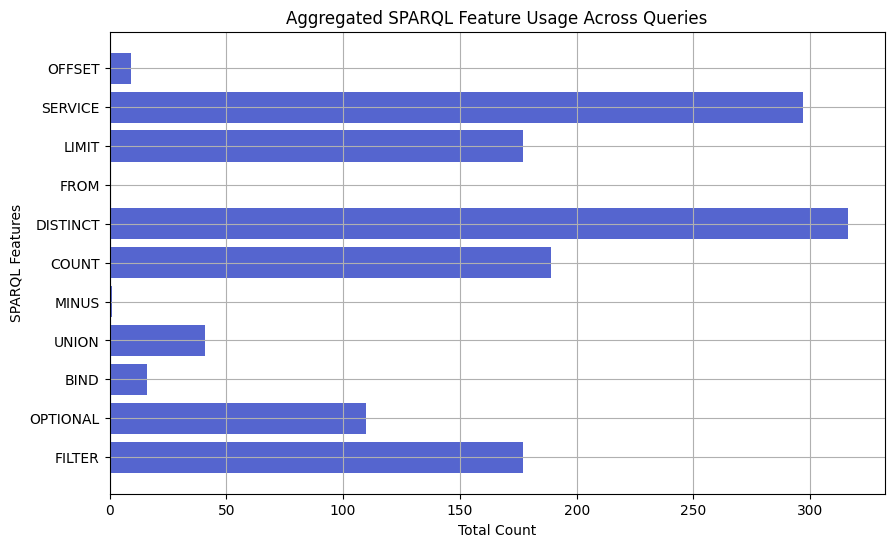

In [ ]:
# List of SPARQL features to look for
sparql_features = ["FILTER", "OPTIONAL", "BIND", "UNION", "MINUS", "COUNT", "DISTINCT", "FROM", "LIMIT", "SERVICE", "OFFSET"]

def count_sparql_features(query, features):
    feature_counts = {feature: len(re.findall(r'\b' + feature + r'\b', query)) for feature in features}
    return feature_counts

# dictionary to accumulate counts for all queries
total_feature_counts = {feature: 0 for feature in sparql_features}

queries = []

for story_id, story_data in data.items():
    story_queries = story_data.get('queries', [])
for query in queries:
    feature_counts = count_sparql_features(query, sparql_features)
    for feature, count in feature_counts.items():
        total_feature_counts[feature] += count

plt.figure(figsize=(10, 6))
plt.barh(list(total_feature_counts.keys()), list(total_feature_counts.values()), color='#5565cf')
plt.title('Aggregated SPARQL Feature Usage Across Queries')
plt.xlabel('Total Count')
plt.ylabel('SPARQL Features')
plt.grid(True)
plt.show()

In [61]:
sparql_features = ["FILTER", "OPTIONAL", "BIND", "UNION", "MINUS", "COUNT", 
                   "DISTINCT", "FROM", "LIMIT", "SERVICE", "OFFSET"]

def count_sparql_features(query, features):
    """
    Count the occurrences of each feature in the query using regex word boundaries.
    Returns a dictionary with the counts.
    """
    feature_counts = {feature: len(re.findall(r'\b' + feature + r'\b', query)) 
                      for feature in features}
    return feature_counts

# Dictionary to store per-story metrics for the simple average metric.
# We'll keep track of the story_id along with total queries and total feature count.
story_feature_metrics = {}

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Loop through each story and calculate the average number of SPARQL features per query.
for story_id, story_data in data.items():
    queries = story_data.get('queries', [])
    total_queries = 0
    total_features_count = 0
    
    for query_dict in queries:
        query = query_dict.get('query', '')
        total_queries += 1
        # Count features for this query.
        feature_counts = count_sparql_features(query, sparql_features)
        # Sum up counts for all features in this query.
        query_feature_count = sum(feature_counts.values())
        total_features_count += query_feature_count
    
    # Compute the simple average metric: total features divided by number of queries.
    if total_queries > 0:
        simple_average = total_features_count / total_queries
    else:
        simple_average = 0.0

    # Round the simple average to two decimals.
    simple_average = round(simple_average, 2)
    
    # Store the metrics for the story using its story_id.
    story_feature_metrics[story_id] = {
        'total_queries': total_queries,
        'total_features_count': total_features_count,
        'sparql_feature_metric': simple_average
    }

# Convert the metrics dictionary into a DataFrame.
df_features = pd.DataFrame.from_dict(story_feature_metrics, orient='index')
df_features.index.name = 'story_id'
df_features.reset_index(inplace=True)

print("Simple SPARQL Feature Metrics per Story:")
print(df_features)

Simple SPARQL Feature Metrics per Story:
    story_id  total_queries  total_features_count  sparql_feature_metric
0   D-hp3wDV              8                    30                   3.75
1   y4Srva15              5                    15                   3.00
2   7qpfziir             11                    37                   3.36
3   Nokx0yU6              3                     6                   2.00
4   gz_gxhYn             11                    31                   2.82
5   U2OtB3XT              8                    26                   3.25
6   v4h_GSI0              4                     9                   2.25
7   1ptR3pru              9                    26                   2.89
8   JQpdcw-d             12                    36                   3.00
9   B9SLlUry              8                    24                   3.00
10  r7i-PG2n              9                    33                   3.67
11  AUmcnOzL              6                    16                   2.67
12  tyK82z

In [62]:
# Normalize the sparql_feature_metric using min-max normalization
min_metric = df_features['sparql_feature_metric'].min()
max_metric = df_features['sparql_feature_metric'].max()

# To avoid division by zero if all values are equal, check if max_metric equals min_metric.
if max_metric > min_metric:
    df_features['normalized_sparql_feature_metric'] = (
        (df_features['sparql_feature_metric'] - min_metric) / (max_metric - min_metric)
    ).round(2)
else:
    df_features['normalized_sparql_feature_metric'] = 0

print("\nNormalized SPARQL Feature Metrics:")
print(df_features[['story_id', 'sparql_feature_metric', 'normalized_sparql_feature_metric']])


Normalized SPARQL Feature Metrics:
    story_id  sparql_feature_metric  normalized_sparql_feature_metric
0   D-hp3wDV                   3.75                              0.51
1   y4Srva15                   3.00                              0.40
2   7qpfziir                   3.36                              0.45
3   Nokx0yU6                   2.00                              0.25
4   gz_gxhYn                   2.82                              0.37
5   U2OtB3XT                   3.25                              0.44
6   v4h_GSI0                   2.25                              0.29
7   1ptR3pru                   2.89                              0.38
8   JQpdcw-d                   3.00                              0.40
9   B9SLlUry                   3.00                              0.40
10  r7i-PG2n                   3.67                              0.50
11  AUmcnOzL                   2.67                              0.35
12  tyK82z37                   2.82                   

In [63]:
df_sparql_proficiency = df_sparql_proficiency.merge(df_features[['story_id', 'normalized_sparql_feature_metric']], on='story_id', how='left')
print(df_sparql_proficiency)

    story_id  total_queries  working_queries  correct_queries  \
0   D-hp3wDV              8                8                8   
1   y4Srva15              5                5                5   
2   7qpfziir             11               11               11   
3   Nokx0yU6              3                3                3   
4   gz_gxhYn             11               11               11   
5   U2OtB3XT              8                8                8   
6   v4h_GSI0              4                4                4   
7   1ptR3pru              9                9                9   
8   JQpdcw-d             12               12               12   
9   B9SLlUry              8                8                8   
10  r7i-PG2n              9                8                8   
11  AUmcnOzL              6                6                5   
12  tyK82z37             11               11                9   
13  IRRbkmZk              8                8                7   
14  Vy4_Rxzv             

In [ ]:
def compute_sparql_proficiency(row):
    """
    Compute the composite SPARQL proficiency score using:
      - normalized working/correct percentage
      - federated bonus
      - SPARQL feature metric

      normalized_wc = (working_percentage + correct_percentage) / 200
      sparql_proficiency = normalized_wc * 0.5 + federated_bonus * 0.2 + sparql_feature_metric * 0.3
    """

    normalized_wc = (row['working_percentage'] + row['correct_percentage']) / 200.0
    
    weight_wc = 0.5      # 50% weight for working/correct queries
    weight_fed = 0.2     # 20% weight for federated bonus
    weight_feat = 0.3    # 30% weight for SPARQL feature metric
    
    proficiency = (normalized_wc * weight_wc +
                   row['federated_bonus'] * weight_fed +
                   row['normalized_sparql_feature_metric'] * weight_feat)
    
    return round(proficiency, 2)

df_sparql_proficiency['sparql_proficiency'] = df_sparql_proficiency.apply(compute_sparql_proficiency, axis=1)

print("Updated DataFrame with composite SPARQL proficiency:")
print(df_sparql_proficiency[['story_id', 'sparql_proficiency']])

Updated DataFrame with composite SPARQL proficiency:
    story_id  sparql_proficiency
0   D-hp3wDV                0.65
1   y4Srva15                0.62
2   7qpfziir                0.64
3   Nokx0yU6                0.57
4   gz_gxhYn                0.61
5   U2OtB3XT                0.63
6   v4h_GSI0                0.59
7   1ptR3pru                0.61
8   JQpdcw-d                0.62
9   B9SLlUry                0.62
10  r7i-PG2n                0.71
11  AUmcnOzL                0.56
12  tyK82z37                0.57
13  IRRbkmZk                0.59
14  Vy4_Rxzv                0.63
15  M9EZmoBI                0.54
16  uhDaBOl1                0.53
17  SXefpzf4                0.59
18  EzsIH_Et                0.59
19  16FP4tfG                0.64
20  sUMoEZI5                0.55
21  _HnVHPjm                0.62
22  4D206Lam                0.59
23  j3ZikN40                0.64
24  BOGODrvZ                0.85
25  abkhtH-r                0.60
26  Huo1mZpJ                0.56
27  JYOzBt8Y           

In [66]:
df_quality = df_quality.reset_index().rename(columns={'index': 'story_id'})
df_combined = pd.merge(df_quality[['story_id', 'quality_score']],
                       df_sparql_proficiency[['story_id', 'sparql_proficiency']],
                       on='story_id', how='inner')

print("Combined DataFrame:")
print(df_combined)

Combined DataFrame:
    story_id  quality_score  sparql_proficiency
0   D-hp3wDV           0.50                0.65
1   y4Srva15           0.42                0.62
2   7qpfziir           0.50                0.64
3   Nokx0yU6           0.50                0.57
4   gz_gxhYn           0.50                0.61
5   U2OtB3XT           1.00                0.63
6   v4h_GSI0           0.50                0.59
7   1ptR3pru           0.30                0.61
8   JQpdcw-d           0.50                0.62
9   B9SLlUry           0.39                0.62
10  r7i-PG2n           0.50                0.71
11  AUmcnOzL           0.50                0.56
12  tyK82z37           0.50                0.57
13  IRRbkmZk           0.50                0.59
14  Vy4_Rxzv           0.44                0.63
15  M9EZmoBI           0.50                0.54
16  uhDaBOl1           0.47                0.53
17  SXefpzf4           0.50                0.59
18  EzsIH_Et           0.43                0.59
19  16FP4tfG        

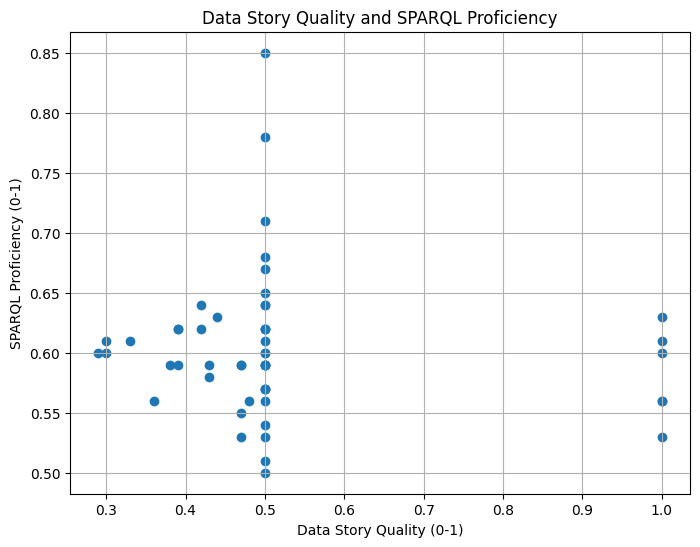

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(df_combined['quality_score'], df_combined['sparql_proficiency'])
plt.xlabel("Data Story Quality (0-1)")
plt.ylabel("SPARQL Proficiency (0-1)")
plt.title("Data Story Quality and SPARQL Proficiency")
plt.grid(True)
plt.show()

In [ ]:
# Pearson
correlation = df_combined['quality_score'].corr(df_combined['sparql_proficiency'])
print("Correlation coefficient:", correlation)

Correlation coefficient: -0.1046645528022192


In [70]:
# Spearman 
spearman_corr = df_combined['quality_score'].corr(df_combined['sparql_proficiency'], method='spearman')
print("Spearman correlation coefficient:", spearman_corr)

Spearman correlation coefficient: -0.04453452839058204


In [94]:
def classify_element(element):
    element = element.strip()
    if element.startswith('?') or element.startswith('$'):
        return 'V'  # Variable
    elif element.startswith('<') and element.endswith('>'):
        return 'C'  # Constant URI
    elif ':' in element and not (element.startswith('"') or element.endswith('"')):
        return 'C'  # Prefixed name
    elif element.startswith('"') and element.endswith('"'):
        return 'C'  # Literal
    else:
        return 'C'

# Function to split the WHERE clause by periods, but only outside of curly braces
def split_outside_braces(where_clause):
    result = []
    buffer = []
    brace_depth = 0

    for char in where_clause:
        if char == '{':
            brace_depth += 1
        elif char == '}':
            brace_depth -= 1
        
        if char == '.' and brace_depth == 0:
            # We're at a period and not inside braces, so we split here
            result.append(''.join(buffer).strip())
            buffer = []
        else:
            # Keep building the current part of the clause
            buffer.append(char)
    
    # Append any remaining part after the last period
    if buffer:
        result.append(''.join(buffer).strip())
    
    return result

# Function to classify and extract triple patterns (updated to use the new splitting method)
def classify_triple_patterns(where_clause):
    # where_clause = extract_where_clause(query)  # Use the provided extract_where_clause function
    patterns = []

    if where_clause:
        # Split WHERE clause into triple groups using the custom function
        triple_groups = split_outside_braces(where_clause)
        
        for group in triple_groups:
            group = group.strip()
            if not group:
                continue
            if 'OPTIONAL' in group or 'SERVICE' in group:
                # Handle OPTIONAL and SERVICE clauses
                inner_triples = re.findall(r'\{(.*?)\}', group, re.DOTALL)
                for triple_block in inner_triples:
                    patterns.extend(classify_triple_patterns(triple_block))  # Recursively classify nested triples
            else:
                # Regex to capture subject-predicate-object triples
                triples = re.findall(
                    r'(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)\s+(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)\s+(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)',
                    group
                )
                for triple in triples:
                    subject, predicate, obj = triple
                    pattern = f"{classify_element(subject)}{classify_element(predicate)}{classify_element(obj)}"
                    patterns.append(pattern)

    return patterns

# Process all queries in the data
patterns_counter = Counter()
for query in queries:
    where_clause = extract_where_clause(query)  # Call extract_where_clause only once here
    if where_clause:

        patterns = classify_triple_patterns(where_clause)
        patterns_counter.update(patterns)

# Calculate the percentage for each pattern
total_triples = sum(patterns_counter.values())
pattern_percentages = {pattern: (count / total_triples) * 100 for pattern, count in patterns_counter.items()}

df = pd.DataFrame.from_dict(pattern_percentages, orient='index', columns=['Percentage'])
df.index.name = 'Pattern'
df = df.reset_index()
df['Percentage'] = df['Percentage'].apply(lambda x: f"{x:.2f}%")

print(df)

  Pattern Percentage
0     VVC      8.12%
1     VCC     23.37%
2     VCV     40.28%
3     CCC     15.81%
4     CCV     10.09%
5     CVC      1.48%
6     VVV      0.43%
7     CVV      0.43%


### Chart Types vs. Story Themes

In [47]:
# import json
# import pandas as pd

# file_path = 'data_stories_summary.json'
# with open(file_path, 'r') as file:
#     data = json.load(file)

# story_data = []

# for story_id, story_info in data.items():
#     viz_types = story_info.get("viz_types", [])
#     title = story_info.get("title", "")
#     description = story_info.get("description", "")
    
#     # Create a list of dictionaries for each story
#     for chart_type in viz_types:
#         story_data.append({"Chart Type": chart_type, "Title": title, "Description": description})

# stories_df = pd.DataFrame(story_data)

In [46]:
# # Group by Chart Type and concatenate titles and descriptions
# grouped_by_chart = stories_df.groupby("Chart Type").agg({
#     "Title": lambda titles: " | ".join(titles),
#     "Description": lambda descriptions: " | ".join(descriptions)
# }).reset_index()

# grouped_by_chart

In [45]:
# import nltk
# from nltk.corpus import stopwords
# import re
# from collections import Counter

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# custom_stopwords = {'melody', 'hands', 'hans', 'music', 'story', 'data'}
# stop_words.update(custom_stopwords)

# # Function to clean and tokenize text
# def tokenize(text):
#     words = re.findall(r'\w+', text.lower())
#     filtered_words = [word for word in words if word not in stop_words and len(word) > 1]  # Remove stopwords and single characters
#     return Counter(filtered_words)

# # Apply tokenization and count words for each chart type
# stories_df['Title Tokens'] = stories_df['Title'].apply(tokenize)
# stories_df['Description Tokens'] = stories_df['Description'].apply(tokenize)

# # Group by Chart Type and aggregate tokens
# grouped_by_chart = stories_df.groupby("Chart Type").agg({
#     "Title Tokens": lambda x: sum(x, Counter()),
#     "Description Tokens": lambda x: sum(x, Counter())
# }).reset_index()

# # Get the top 10 words for titles and descriptions
# grouped_by_chart['Top Words in Titles'] = grouped_by_chart['Title Tokens'].apply(lambda x: x.most_common(10))
# grouped_by_chart['Top Words in Descriptions'] = grouped_by_chart['Description Tokens'].apply(lambda x: x.most_common(10))

# # Display the DataFrame with top words
# grouped_by_chart[['Chart Type', 'Top Words in Titles', 'Top Words in Descriptions']]

In [44]:
# import matplotlib.pyplot as plt

# def extract_top_words(word_count_list):
#     words = []
#     counts = []
#     for word, count in word_count_list:
#         words.append(word)
#         counts.append(count)
#     return words, counts

# # Plot top words for each chart type
# fig, axes = plt.subplots(len(grouped_by_chart), 2, figsize=(15, 5 * len(grouped_by_chart)))

# for i, row in grouped_by_chart.iterrows():
#     chart_type = row['Chart Type']
#     title_words, title_counts = extract_top_words(row['Top Words in Titles'])
#     desc_words, desc_counts = extract_top_words(row['Top Words in Descriptions'])
    
#     # Plot for Title Words
#     axes[i, 0].barh(title_words, title_counts, color='skyblue')
#     axes[i, 0].set_title(f'Top Words in Titles for {chart_type}')
#     axes[i, 0].invert_yaxis()  # to display the highest counts on top
    
#     # Plot for Description Words
#     axes[i, 1].barh(desc_words, desc_counts, color='lightgreen')
#     axes[i, 1].set_title(f'Top Words in Descriptions for {chart_type}')
#     axes[i, 1].invert_yaxis()

# plt.tight_layout()
# plt.show()

### Common Themes in Data Stories

In [43]:
# text_data = " ".join(stories_df['Title'].tolist() + stories_df['Description'].tolist())

# # Clean the text
# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'\W+', ' ', text)
#     # Remove stopwords (using the manually defined stopwords from earlier)
#     tokens = text.split()
#     filtered_words = [word for word in tokens if word not in stop_words and len(word) > 1]
#     return filtered_words

# cleaned_text = preprocess_text(text_data)

# # Count the most common words
# word_counts = Counter(cleaned_text)
# common_words = word_counts.most_common(20)  # Get top 20 common words

# common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

In [42]:
# plt.figure(figsize=(10, 8))
# plt.barh(common_words_df['Word'], common_words_df['Frequency'], color='skyblue')
# plt.xlabel('Frequency')
# plt.title('Top 20 Common Words in Data Stories')
# plt.gca().invert_yaxis()
# plt.show()

In [41]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# # Convert text data into a document-term matrix
# vectorizer = CountVectorizer(stop_words='english')
# dtm = vectorizer.fit_transform([" ".join(cleaned_text)])

# # Perform LDA
# lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components for the number of topics
# lda.fit(dtm)

# # Display the top words for each topic
# for index, topic in enumerate(lda.components_):
#     print(f"Top 10 words for Topic #{index + 1}:")
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
#     print("\n")